# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [42]:
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-c_ndvj1x
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-c_ndvj1x


In [43]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain. Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [44]:
from google.colab import  drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
data_path = r'/content/drive/MyDrive/SOCI Computational Content Analysis/data'

In [ ]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#content/drive/MyDrive//data/pyAnno/testdata_numerical.txt"
x = np.loadtxt(f"{data_path}/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [ ]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [ ]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [ ]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations, 4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


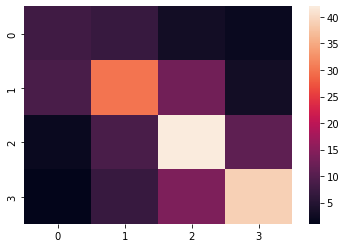

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [ ]:
fleiss_kappa(anno.annotations)

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations)

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


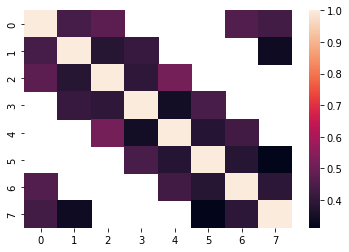

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

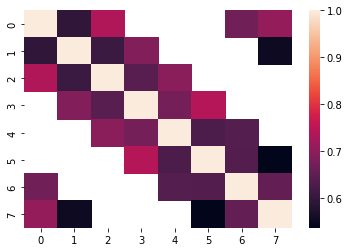

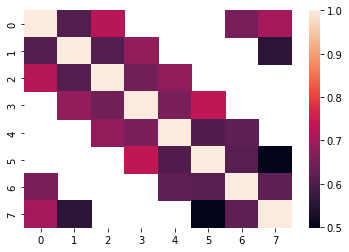

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674661?wrap=1), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [240]:
import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_US_Technology_ies.xlsx')

In [241]:
#extracting data for external coders from corpora 

news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)
news_df_reduced

,body
0,<p> Thank you for visiting nature.com . You ar...
1,<p> Mayans M.C. does n't shy away from sending...
2,<h> Japan Is About to Start Testing The Feasib...
3,<h> Krebs on Security <h> In-depth security ne...
4,<p> Morgan Stanley has valued Tesla 's autonom...
...,...
1811,"<p> In the early 1990s , the burgeoning black ..."
1812,<p> The furor that has flared around virtually...
1813,"<h> We saw final moments of MH370 , say fisher..."
1814,<h> The Coming of Age of Biotechnology <p> Sin...


In [242]:
def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text
news_df_reduced['body'] = news_df_reduced['body'].apply(clean_raw_text)
news_df_reduced

,body
0,Thank you for visiting nature.com . You are us...
1,Mayans M.C. does n't shy away from sending a c...
2,Japan Is About to Start Testing The Feasibilit...
3,Krebs on Security In-depth security news and ...
4,Morgan Stanley has valued Tesla 's autonomous ...
...,...
1811,"In the early 1990s , the burgeoning black meta..."
1812,The furor that has flared around virtually eve...
1813,"We saw final moments of MH370 , say fishermen ..."
1814,The Coming of Age of Biotechnology Since its b...


In [243]:
n, m = 500, 2000
len_texts = news_df_reduced['body'].apply(len)
news_df_reduced = news_df_reduced[(len_texts > n) & (len_texts < m)] # filtering text between n and m parameters. 
news_df_reduced 

,body
11,Executives from Facebook and Twitter will appe...
16,"Nasdaq tumbles below 8,000 , on the verge of w..."
25,Facebook has accused BlackBerry of stealing it...
38,Dr. John Halamka : Test IT in places ' toleran...
39,Facebook and Twitter executives assured Congre...
...,...
1797,"FRANKSVILLE -- For the third year , the Third ..."
1801,China Is Growing Cotton and Potatoes on the Fa...
1807,We noticed that your browser is blocking ads -...
1808,""" We expect excellence every single day in Jef..."


In [244]:
news_df_reduced = news_df_reduced.reset_index()
news_df_reduced.to_excel("NOW body for coders.xlsx")

In [245]:
x = np.loadtxt(f"{data_path}/Final Project NOW/NOW_content_pulled numbers.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[4])

#Sentiment analysis: 1= negative, 2=neutral, 3=positive, 4= NA

In [246]:
anno.annotations

array([[ 0,  0,  0],
       [ 1,  1,  2],
       [ 1,  1,  1],
       [ 2,  1,  1],
       [ 2,  1, -1],
       [-1, -1,  1],
       [ 2,  2,  2],
       [ 1,  1,  1],
       [ 2,  2,  2],
       [-1, -1,  1],
       [-1,  2,  0],
       [-1, -1,  1],
       [ 2,  0,  2],
       [-1,  2,  0],
       [ 2,  2,  2],
       [ 2,  2,  1],
       [ 1,  1,  1],
       [ 0,  2,  1],
       [-1,  1,  2],
       [ 2,  1,  2],
       [ 1,  1,  2],
       [ 0,  2,  1],
       [-1,  2, -1],
       [ 0,  2,  0],
       [ 2,  2,  1],
       [ 2,  2,  2],
       [-1,  1,  1],
       [-1, -1,  2],
       [ 1,  1,  0],
       [ 1,  0,  0]])

In [247]:
pyanno.measures.agreement.labels_frequency(anno.annotations, 3)

array([0.17333333, 0.4       , 0.42666667])

[[1. 0. 3.]
 [1. 6. 0.]
 [1. 3. 6.]]


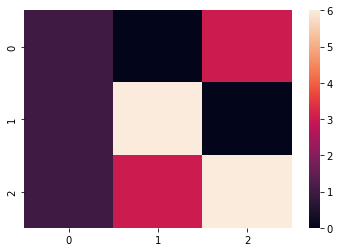

In [248]:
n_coder_1 = 0
n_coder_2 = 1
confusion_matrix = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,n_coder_1], anno.annotations[:,n_coder_2], 3)
print(confusion_matrix)
ac = seaborn.heatmap(confusion_matrix)
plt.show()

In [249]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.37757114680191606

In [ ]:
fleiss_kappa(anno.annotations)

In [251]:
krippendorffs_alpha(anno.annotations)

0.1885336273428887

In [252]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.38278931750741846

In [253]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.27516123908742135

Cohen's  𝜅  for all pairs of coders that have coded against one another is very poor (.27*). Some, if i want to make this more robust I should 1) make people to code more data (for this exercise the coders only worked with 30 texts). Second, since I'm working with sentiment analysis it would be necessary to re-adjust the inter-agreement after these cases, discuss disagreements and continue coding. Finally, a thid source of variation for this could be that coders were no native English speakers. 

*/ Following Kappa score scale, between 0.21–0.40 could be consider as "fair", but still is too low. 

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [ ]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [ ]:
noise = 0.2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=noise)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=noise)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=noise)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=noise)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=noise)

TypeError: ignored

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [ ]:
dfTrain

,vect,category
229,"[-0.3090231116612818, -0.23883053058686876]",1
752,"[-0.14300271222118371, 0.10725869881066397]",0
912,"[0.03260160915766156, -0.29507934667230795]",0
936,"[0.13804905409188398, 0.014974847140195754]",0
743,"[-0.5751244643691407, -0.5346788190587402]",1
...,...,...
588,"[0.10933633017336636, -0.3367189882548643]",0
372,"[0.09239472325329695, 0.004362261971631133]",0
641,"[-0.327487586679623, 0.1315370785554295]",1
209,"[-0.2801135385766554, 0.6561882021802854]",1


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


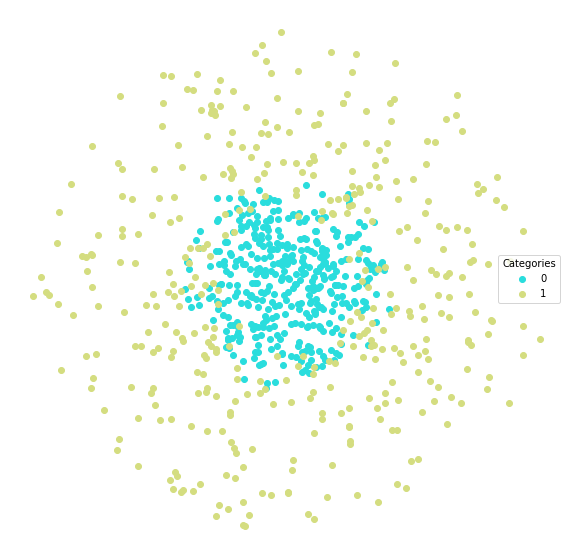

In [ ]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [ ]:
dfTrain['vect']

229     [-0.3090231116612818, -0.23883053058686876]
752     [-0.14300271222118371, 0.10725869881066397]
912     [0.03260160915766156, -0.29507934667230795]
936     [0.13804905409188398, 0.014974847140195754]
743      [-0.5751244643691407, -0.5346788190587402]
                           ...                     
588      [0.10933633017336636, -0.3367189882548643]
372     [0.09239472325329695, 0.004362261971631133]
641        [-0.327487586679623, 0.1315370785554295]
209       [-0.2801135385766554, 0.6561882021802854]
747    [-0.40457785038666316, -0.23460372685167008]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [ ]:
np.stack(dfTrain['vect'])

array([[-0.30902311, -0.23883053],
       [-0.14300271,  0.1072587 ],
       [ 0.03260161, -0.29507935],
       ...,
       [-0.32748759,  0.13153708],
       [-0.28011354,  0.6561882 ],
       [-0.40457785, -0.23460373]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.41,0.590636,0.575472,0.543202,0.622449
1,0.41,0.590636,0.606383,0.563861,0.558824


This lets us look at which classes do better:

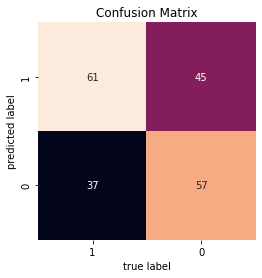

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

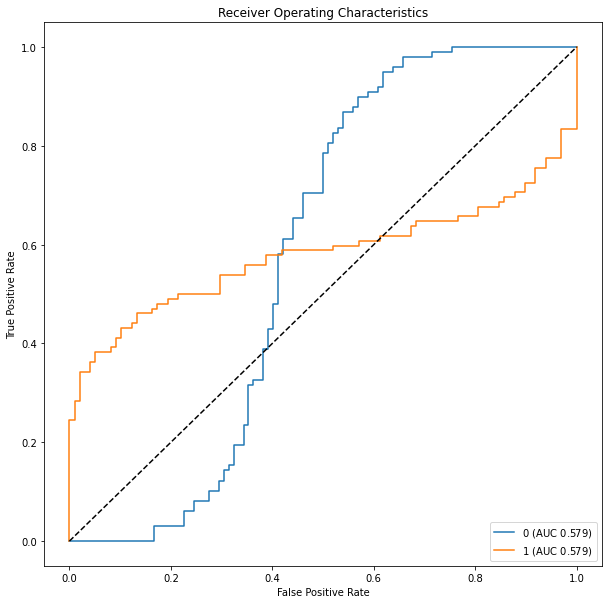

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


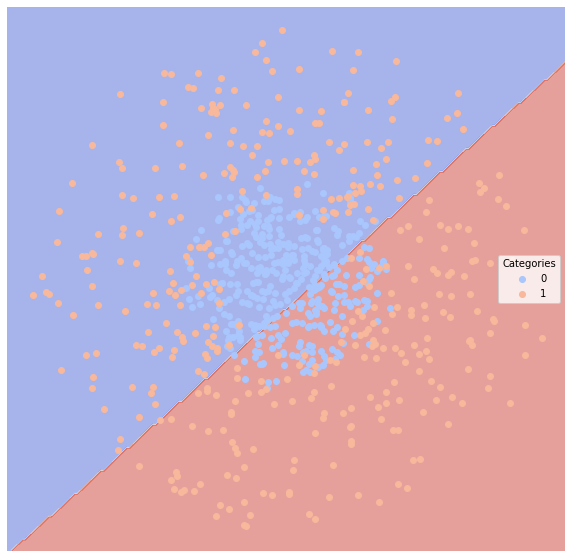

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [ ]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory=data_path), test_size=.2)

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


In [ ]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.082979,0.878263,0.853211,0.732976,0.801724
comp.sys.mac.hardware,0.129787,0.837784,0.694215,0.591009,0.777778
comp.windows.x,0.093617,0.895268,0.820690,0.751160,0.868613
misc.forsale,0.127660,0.798419,0.757895,0.579351,0.660550


In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.059574,0.925677,0.866667,0.802543,0.896552
comp.sys.mac.hardware,0.057447,0.923726,0.864865,0.794301,0.888889
comp.windows.x,0.040426,0.947842,0.940299,0.888204,0.919708
misc.forsale,0.055319,0.915957,0.895238,0.803955,0.862385


In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.202128,0.851330,0.552239,0.539074,0.956897
comp.sys.mac.hardware,0.091489,0.823665,0.911392,0.684191,0.666667
comp.windows.x,0.087234,0.854661,0.980000,0.784001,0.715328
misc.forsale,0.091489,0.841178,0.866667,0.686141,0.715596


In [ ]:
#Analogizes
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.478723,0.514124,0.257778,0.252293,0.500000
comp.sys.mac.hardware,0.442553,0.521051,0.247475,0.237812,0.453704
comp.windows.x,0.257447,0.558394,1.000000,0.374235,0.116788
misc.forsale,0.238298,0.540674,0.451613,0.260133,0.128440


In [ ]:
#Symbolists
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


In [ ]:
#Symbolists
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

In [ ]:
#Connectionists
clf = sklearn.neural_network.MLPClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

In [ ]:
#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# 1
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

In [ ]:
noise = 0.2
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=noise)

In [ ]:
# 2
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(3) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 3 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

In [ ]:
noise = 0.2
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size= noise)

In [ ]:
# 3 (500 num per cat)
def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 3 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 3) for i in range(3 * numPerCategory)],
        'category' : [i % 3 for i in range(3 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=noise)


In [ ]:
#from sklearn.naive_bayes import GaussianNB
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf = sklearn.naive_bayes.GaussianNB()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.11,0.892011,0.928571,0.872170,0.858491
1,0.11,0.892011,0.852941,0.824424,0.925532


In [ ]:
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.11,0.892011,0.928571,0.872170,0.858491
1,0.11,0.892011,0.852941,0.824424,0.925532


In [ ]:
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.145,0.862003,0.975309,0.861881,0.745283
1,0.145,0.862003,0.773109,0.766660,0.978723


In [ ]:
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.15,0.850662,0.872549,0.817612,0.839623
1,0.15,0.850662,0.826531,0.777223,0.861702


In [ ]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.11,0.892011,0.928571,0.872170,0.858491
1,0.11,0.892011,0.852941,0.824424,0.925532


In [ ]:
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.125,0.874849,0.885714,0.842089,0.877358
1,0.125,0.874849,0.863158,0.812968,0.872340


In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.885488,0.902913,0.857178,0.877358
1,0.115,0.885488,0.865979,0.823854,0.893617


In [ ]:
clf = sklearn.neural_network.MLPClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.886692,0.919192,0.864118,0.858491
1,0.115,0.886692,0.851485,0.819018,0.914894


In [ ]:
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.898434,0.890909,0.863671,0.924528
1,0.1,0.898434,0.911111,0.854799,0.872340


In [ ]:
# 4 (1000 num per cat)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=noise)

def andSplit(noise = 0, numPerCategory = 1000):
    def genPoint(cat):
        y = np.random.random_sample() * 3 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 3) for i in range(3 * numPerCategory)],
        'category' : [i % 3 for i in range(3 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB()

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.900811,0.873786,0.84573,0.927835
1,0.1,0.900811,0.927835,0.87573,0.873786


For Naive Bayes increasing the number of categories seems to decrease the precision and AUC for a random sample data.

In [ ]:
# 5 (500 num per cat)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])


In [ ]:
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.135,0.86623,0.830189,0.798161,0.907216
1,0.135,0.86623,0.904255,0.836230,0.825243


In [ ]:
# 6 (1300 num per cat)

def xorSplit(noise = 0, numPerCategory = 1300):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

In [ ]:
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.135,0.86623,0.830189,0.798161,0.907216
1,0.135,0.86623,0.904255,0.836230,0.825243


In [ ]:
# 7 (500 num per cat)
def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=noise)


In [ ]:
clf = sklearn.naive_bayes.GaussianNB()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.08,0.917496,0.902655,0.885475,0.953271
1,0.08,0.917496,0.942529,0.886047,0.881720


In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.11,0.888051,0.882883,0.853622,0.915888
1,0.11,0.888051,0.898876,0.838227,0.860215


In [ ]:
clf = sklearn.neural_network.MLPClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.085,0.911416,0.887931,0.874737,0.962617
1,0.085,0.911416,0.952381,0.884252,0.860215


In [ ]:
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.535,0.5,0.000,0.535,0.0
1,0.535,0.5,0.465,0.465,1.0


In [ ]:
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.535,0.5,0.000,0.535,0.0
1,0.535,0.5,0.465,0.465,1.0


In [ ]:
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.125,0.871219,0.853448,0.829639,0.925234
1,0.125,0.871219,0.904762,0.824375,0.817204


In [ ]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.63,0.386594,0.313725,0.501912,0.149533
1,0.63,0.386594,0.389262,0.417765,0.623656


In [ ]:
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.12,0.877299,0.867257,0.839310,0.915888
1,0.12,0.877299,0.896552,0.826947,0.838710


In [ ]:
# 8 (30 num per cat)
def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

In [ ]:
clf = sklearn.naive_bayes.GaussianNB()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.900811,0.873786,0.84573,0.927835
1,0.1,0.900811,0.927835,0.87573,0.873786


In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.125,0.876239,0.839623,0.810375,0.917526
1,0.125,0.876239,0.914894,0.848892,0.834951


In [ ]:
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.900811,0.873786,0.84573,0.927835
1,0.1,0.900811,0.927835,0.87573,0.873786


In [ ]:
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.905665,0.882353,0.853678,0.927835
1,0.095,0.905665,0.928571,0.880388,0.883495


In [ ]:
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.12,0.881093,0.847619,0.817712,0.917526
1,0.12,0.881093,0.915789,0.853531,0.844660


In [ ]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.905965,0.8750,0.850876,0.938144
1,0.095,0.905965,0.9375,0.884175,0.873786


In [ ]:
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.14,0.861676,0.816514,0.789172,0.917526
1,0.14,0.861676,0.912088,0.834983,0.805825


In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.14,0.861075,0.828571,0.793152,0.896907
1,0.14,0.861075,0.894737,0.828375,0.825243


In [ ]:
clf = sklearn.neural_network.MLPClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.09,0.91082,0.883495,0.858846,0.938144
1,0.09,0.91082,0.938144,0.888846,0.883495


In [ ]:
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.135,0.86623,0.830189,0.798161,0.907216
1,0.135,0.86623,0.904255,0.836230,0.825243


### Now let's try with the real datasets

In [ ]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory=data_path), test_size=.2)

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


We'll see that with the classifier KNeighbors does not perform very well. 

In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.078723,0.922664,0.822368,0.782729,0.925926
comp.sys.mac.hardware,0.070213,0.877220,0.915789,0.764564,0.776786
comp.windows.x,0.036170,0.950704,0.944000,0.891527,0.921875
misc.forsale,0.048936,0.930035,0.867347,0.797324,0.894737


In [ ]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.082979,0.878263,0.853211,0.732976,0.801724
comp.sys.mac.hardware,0.129787,0.837784,0.694215,0.591009,0.777778
comp.windows.x,0.093617,0.895268,0.820690,0.751160,0.868613
misc.forsale,0.127660,0.798419,0.757895,0.579351,0.660550


In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.059574,0.925677,0.866667,0.802543,0.896552
comp.sys.mac.hardware,0.057447,0.923726,0.864865,0.794301,0.888889
comp.windows.x,0.040426,0.947842,0.940299,0.888204,0.919708
misc.forsale,0.055319,0.915957,0.895238,0.803955,0.862385


In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.202128,0.851330,0.552239,0.539074,0.956897
comp.sys.mac.hardware,0.091489,0.823665,0.911392,0.684191,0.666667
comp.windows.x,0.087234,0.854661,0.980000,0.784001,0.715328
misc.forsale,0.091489,0.841178,0.866667,0.686141,0.715596


In [ ]:
#Analogizes
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.478723,0.514124,0.257778,0.252293,0.500000
comp.sys.mac.hardware,0.442553,0.521051,0.247475,0.237812,0.453704
comp.windows.x,0.257447,0.558394,1.000000,0.374235,0.116788
misc.forsale,0.238298,0.540674,0.451613,0.260133,0.128440


In [ ]:
#Symbolists
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.185106,0.792758,0.657895,0.561798,0.740741
comp.sys.mac.hardware,0.148936,0.754988,0.744186,0.527377,0.571429
comp.windows.x,0.125532,0.840415,0.771654,0.654627,0.765625
misc.forsale,0.131915,0.815158,0.657143,0.532612,0.726316


In [ ]:
#Symbolists
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.117021,0.873687,0.766667,0.695640,0.851852
comp.sys.mac.hardware,0.074468,0.871359,0.905263,0.750432,0.767857
comp.windows.x,0.051064,0.930693,0.919355,0.848588,0.890625
misc.forsale,0.063830,0.912842,0.821782,0.743510,0.873684


In [ ]:
lucem_illud.plotregions(clf, dfTrain)

In [ ]:
#Connectionists
clf = sklearn.neural_network.MLPClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.082979,0.899779,0.852941,0.773323,0.859259
comp.sys.mac.hardware,0.087234,0.862979,0.851485,0.709138,0.767857
comp.windows.x,0.025532,0.965346,0.960317,0.922694,0.945312
misc.forsale,0.085106,0.891649,0.757009,0.675237,0.852632


In [ ]:
#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

Now let's go with de small data set from Senators. Since many of the classifiers look overfitted in our models, it seems that the best classfier for this data set could be Naive Bayes.

In [ ]:
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(dataDirectory=data_path), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory=data_path), test_size=.2)

Loading senate data
Converting to vectors


In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.008772,0.988462,1.000000,0.985695,0.976923
Clinton,0.008772,0.988462,0.986047,0.986047,1.000000


In [ ]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.140351,0.851089,0.815385,0.735028,0.815385
Clinton,0.140351,0.851089,0.886792,0.856576,0.886792


In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.0,1.0,1.0,1.0,1.0
Clinton,0.0,1.0,1.0,1.0,1.0


In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.119883,0.848258,0.958763,0.794071,0.715385
Clinton,0.119883,0.848258,0.848980,0.844657,0.981132


In [ ]:
#Analogizes
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.125731,0.870319,0.822222,0.757607,0.853846
Clinton,0.125731,0.870319,0.908213,0.875571,0.886792


In [ ]:
#Symbolists
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.0,1.0,1.0,1.0,1.0
Clinton,0.0,1.0,1.0,1.0,1.0


In [ ]:
#Symbolists
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.0,1.0,1.0,1.0,1.0
Clinton,0.0,1.0,1.0,1.0,1.0


In [ ]:
#Connectionists
clf = sklearn.neural_network.MLPClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.02924,0.970464,0.954545,0.936871,0.969231
Clinton,0.02924,0.970464,0.980952,0.970733,0.971698


In [ ]:
#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.0,1.0,1.0,1.0,1.0
Clinton,0.0,1.0,1.0,1.0,1.0


Now let's try with large sample of senators. One insight of running these classifiers is that algorithms like Naïve Bayes and Linear and Logistic regression are quick to run. Whereas those classifiers like SVM, Neural networks with high convergence time, and random forests, need a lot of time to train the data (in fact, some of them I had to stop it because they were taking a lot of time executing it)

Additionally, I included the multinomial logistic regression (given the categorial data of the variable)



In [ ]:
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory=data_path), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory=data_path), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory=data_path), test_size=.2)

Loading senator: Klobuchar
Loading senator: Kennedy
Loading senator: Kyl
Loading senator: Kohl
Loading senator: Kerry
Converting to vectors


In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Klobuchar,0.011524,0.938356,1.000000,0.888236,0.876712
Kennedy,0.052497,0.950820,0.909589,0.898430,0.976471
Kerry,0.023047,0.969989,0.946524,0.915837,0.956757
Kyl,0.019206,0.929958,0.988636,0.869523,0.861386
Kohl,0.006402,0.969512,1.000000,0.945426,0.939024


In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Klobuchar,0.052497,0.743750,0.900000,0.491211,0.493151
Kennedy,0.266325,0.756763,0.630952,0.618295,0.935294
Kerry,0.175416,0.735965,0.648148,0.470301,0.567568
Kyl,0.089629,0.670326,0.897436,0.395500,0.346535
Kohl,0.064020,0.705886,0.944444,0.453059,0.414634


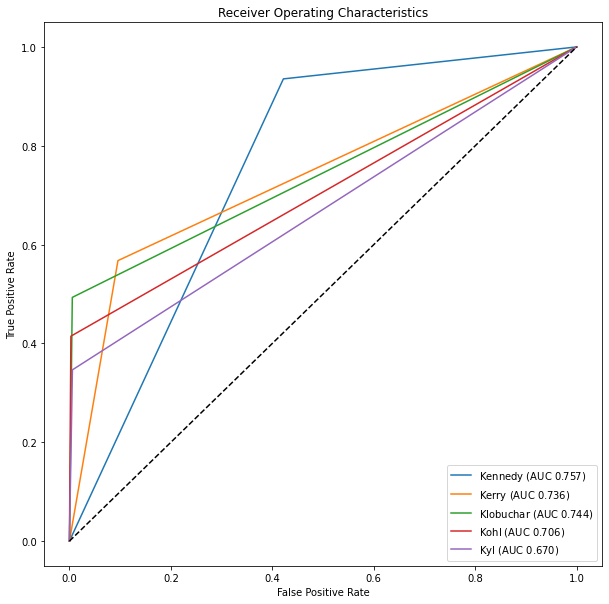

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

In [ ]:
#Analogizes
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

In [ ]:
#Symbolists
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Klobuchar,0.002561,0.998588,0.973333,0.973333,1.000000
Kennedy,0.002561,0.997059,1.000000,0.996678,0.994118
Kerry,0.000000,1.000000,1.000000,1.000000,1.000000
Kyl,0.000000,1.000000,1.000000,1.000000,1.000000
Kohl,0.002561,0.993187,0.987805,0.977039,0.987805


In [ ]:
#Symbolists
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Klobuchar,0.002561,0.986301,1.000000,0.975164,0.972603
Kennedy,0.005122,0.995128,0.991228,0.989593,0.997059
Kerry,0.002561,0.996458,0.994595,0.990499,0.994595
Kyl,0.000000,1.000000,1.000000,1.000000,1.000000
Kohl,0.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#Connectionists
clf = sklearn.neural_network.MLPClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Klobuchar,0.007682,0.965047,0.985507,0.924409,0.931507
Kennedy,0.053777,0.946992,0.925714,0.902638,0.952941
Kerry,0.039693,0.955356,0.892857,0.857399,0.945946
Kyl,0.014085,0.949760,0.989130,0.904001,0.900990
Kohl,0.010243,0.951220,1.000000,0.912682,0.902439


In [ ]:
#Multinomial Regression
clf = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Klobuchar,0.014085,0.920290,1.000000,0.854664,0.840580
Kennedy,0.053777,0.950812,0.900826,0.892278,0.981982
Kerry,0.017926,0.979339,0.954082,0.935638,0.973958
Kyl,0.025608,0.910714,1.000000,0.847037,0.821429
Kohl,0.003841,0.980000,1.000000,0.963841,0.960000


In [ ]:
#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

Finally, let's turn into the spam dataset. Given the type of data, binary, logistic regression seems to naturally fit with this dataset. k-Nearest Neighbors, Decision Trees also perform well.

In [ ]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory=data_path), test_size=.2)

Loading Spam
Loading Ham
Converting to vectors


In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.119708,0.613663,0.923077,0.329806,0.230769
not spam,0.119708,0.613663,0.878604,0.878499,0.996558


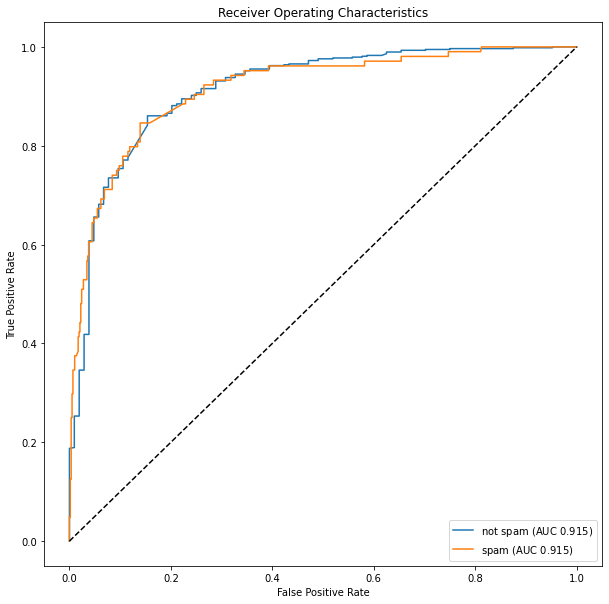

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.183942,0.769206,0.434524,0.350258,0.701923
not spam,0.183942,0.769206,0.940039,0.925018,0.836489


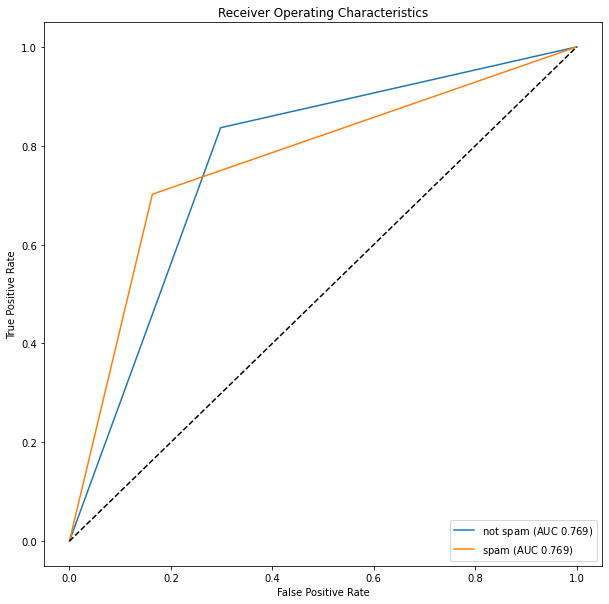

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.09781,0.733144,0.784615,0.462136,0.490385
not spam,0.09781,0.733144,0.914516,0.912918,0.975904


In [ ]:
#Analogizes
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.09781,0.689726,0.930233,0.451212,0.384615
not spam,0.09781,0.689726,0.900312,0.900042,0.994836


In [ ]:
#Analogizes
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.10365,0.713913,0.770492,0.431415,0.451923
not spam,0.10365,0.713913,0.908654,0.907197,0.975904


In [ ]:
#Symbolists
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.09635,0.769529,0.731707,0.486372,0.576923
not spam,0.09635,0.769529,0.927032,0.924046,0.962134


In [ ]:
#Symbolists
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.090511,0.780865,0.756098,0.512064,0.596154
not spam,0.090511,0.780865,0.930348,0.927520,0.965577


In [ ]:
#Connectionists
clf = sklearn.neural_network.MLPClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.09635,0.801106,0.693878,0.506244,0.653846
not spam,0.09635,0.801106,0.938671,0.933998,0.948365


In [ ]:
#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.115328,0.639928,0.857143,0.355282,0.288462
not spam,0.115328,0.639928,0.886154,0.885827,0.991394


# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [ ]:
ObamaClintonReleases = pandas.read_csv(f'{data_path}/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [ ]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [ ]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [ ]:
#ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

ObamaClintonReleases['category'] =  ObamaClintonReleases['targetSenator'].apply(lambda x: x == 'Obama')


# Si tuviese más de dos categorías
d = {'Obama': 1, 'Clinton': 0}
ObamaClintonReleases['category'] =  ObamaClintonReleases['targetSenator'].apply(lambda x: d[x])
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama,1,"[Obama, Calls, on, IRS, to, Protect, Taxpayers...","[obama, call, irs, protect, taxpayer, privacy,..."
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama,1,"[Statement, from, Senator, Barack, Obama, on, ...","[statement, senator, barack, obama, dodd, shel..."
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama,1,"[Obama, Says, Bill, Will, Help, Cut, Off, Supp...","[obama, say, bill, help, cut, supply, dangerou..."
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama,1,"[Obama, Durbin, Say, Illinois, Will, Receive, ...","[obama, durbin, illinois, receive, percent, fu..."
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama,1,"[Obama, Introduces, Bill, to, Help, Tap, Power...","[obama, introduce, bill, help, tap, power, gen..."
...,...,...,...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton,0,"[September, 1, 2005, Senator, Clinton, Visit, ...","[september, senator, clinton, visit, infotonic..."
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton,0,"[September, 1, 2005, Senator, Clinton, Announc...","[september, senator, clinton, announce, expans..."
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton,0,"[September, 1, 2005, Senator, Clinton, Joins, ...","[september, senator, clinton, join, local, com..."
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton,0,"[September, 1, 2006, Clintons, Meet, with, Caz...","[september, clintons, meet, cazenovia, college..."


Tokenize and normalize

In [ ]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [ ]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [ ]:
TFVects.shape

(1367, 11381)

We can save this in the dataframe to make things easier

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


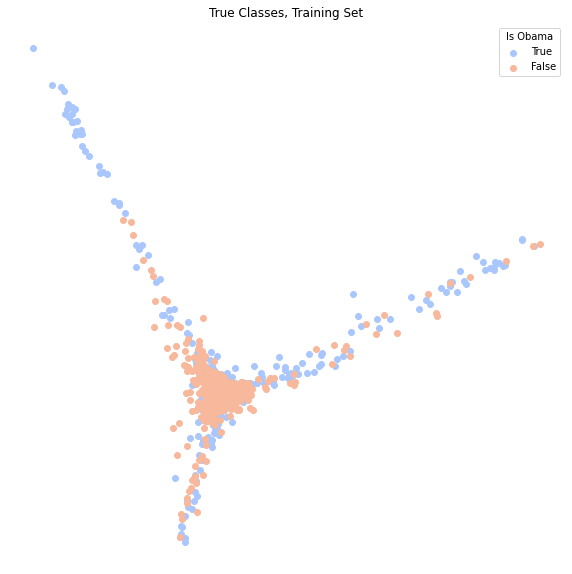

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category'].eq(True)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

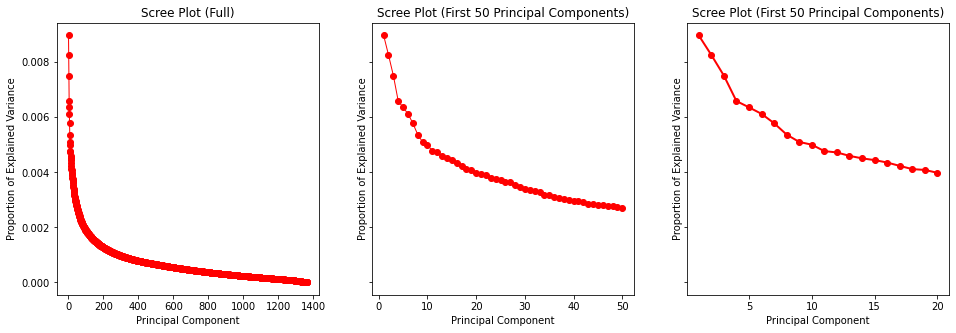

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6613021214337966

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6783625730994152

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7461594732991953
Testing:
0.7339181286549707


Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8376005852231163
Testing:
0.783625730994152


Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8792977322604243
Testing:
0.7894736842105263


This is becoming ridiculous (400)!

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9129480614484272
Testing:
0.8070175438596491


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.8163862472567667


Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.7602339181286549


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [46]:
#Training and test

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_Cande.xlsx')
#news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df['text'] = news_df['text'].apply(clean_raw_text)
news_df = news_df.drop(news_df.columns[[0]], axis=1)
news_df['category'] = news_df['category'].apply(int)
news_df = news_df[news_df['category'] != 4]
news_df['category'] = news_df['category'].apply(lambda x: x-1)
news_df

,text,category
0,"Navy pilot Lt. Cmdr. Mike "" MOB "" Tremel , lef...",0
1,"the war on terror began 17 years ago , the lar...",2
2,Ministry Eyes Blockchain to Boost Trust In Cha...,1
3,impact of ' technological change and innovatio...,1
5,"pauses its review of T-Mobile , Sprint merger ...",1
6,launches Ghana 's first satellite internet ser...,2
7,watch the news on television at a train statio...,1
8,'s promising blockchain asset exchange has onc...,2
9,Are 3 Hot Things to Know About Stocks Right No...,1
10,"new Harris Poll has just been released : "" the...",0


In [7]:
holdBackFraction = .2
news_df_train, news_df_test= sklearn.model_selection.train_test_split(news_df, test_size=holdBackFraction)

In [15]:
# Fit vectors
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(news_df_train['text'])

# Create vectors
news_df_train['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

# PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(news_df_train['vect'], axis=0))
news_df_train['pca'] = [r for r in reduced_data]
news_df_train['pca_reduced_10'] = news_df_train['pca'].apply(lambda x: x[:10])

# Logistic
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(news_df_train['pca_reduced_10'], axis=0), news_df_train['category'])

LogisticRegression()

In [16]:
# Check logistic score (training)
logistic.score(np.stack(news_df_train['pca_reduced_10'], axis=0), news_df_train['category'])

0.5909090909090909

In [17]:
#Create vectors
TFVects_test = TFVectorizer.transform(news_df_test['text'])
news_df_test['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(news_df_test['vect'], axis=0))
news_df_test['pca'] = [r for r in reduced_data_test]
news_df_test['pca_reduced_10'] = news_df_test['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(news_df_test['pca_reduced_10'], axis=0), news_df_test['category'])

0.16666666666666666

In [18]:
news_df_train_to_evaluate = pandas.DataFrame()
news_df_train_to_evaluate['vect']= news_df_train['pca_reduced_10']
news_df_train_to_evaluate['category']= news_df_train['category']
lucem_illud.evaluateClassifier(logistic, news_df_train_to_evaluate)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.227273,0.500000,0.00,0.227273,0.000000
1,0.409091,0.590909,0.55,0.550000,1.000000
2,0.181818,0.666667,1.00,0.515152,0.333333


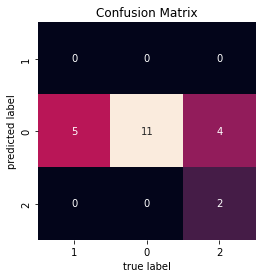

In [12]:
lucem_illud.plotConfusionMatrix(logistic, news_df_train_to_evaluate)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


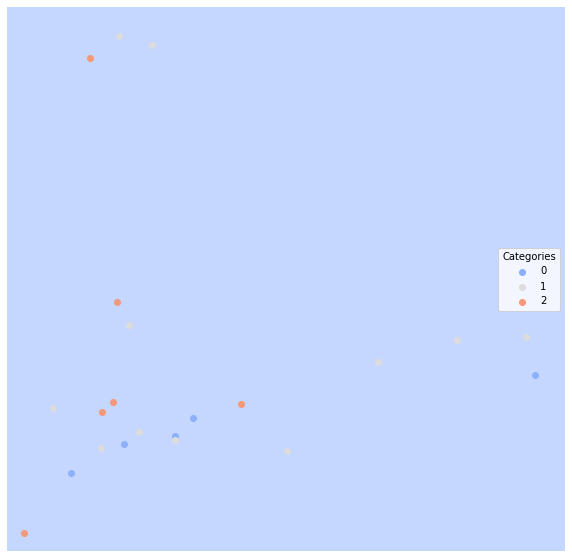

In [19]:
lucem_illud.plotregions(logistic, news_df_train_to_evaluate)

In [25]:
# Extrapolation

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_US_Technology_ies.xlsx')
news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df_reduced['body'] = news_df_reduced['body'].apply(clean_raw_text)

In [29]:
news_df_extrapolated = pandas.DataFrame(dtype='object')
news_df_extrapolated ['body'] = news_df_reduced['body']
news_df_extrapolated

,body
0,Thank you for visiting nature.com . You are us...
1,Mayans M.C. does n't shy away from sending a c...
2,Japan Is About to Start Testing The Feasibilit...
3,Krebs on Security In-depth security news and ...
4,Morgan Stanley has valued Tesla 's autonomous ...
...,...
1811,"In the early 1990s , the burgeoning black meta..."
1812,The furor that has flared around virtually eve...
1813,"We saw final moments of MH370 , say fishermen ..."
1814,The Coming of Age of Biotechnology Since its b...


In [ ]:
#news_df_extrapolated = pandas.DataFrame(dtype='object')
#news_df_extrapolated['text'] = ['Some text', 'Some other text to extrapolate']
#news_df_extrapolated

In [30]:
#Create vectors
TFVects_extrapolated = TFVectorizer.transform(news_df_extrapolated['body'])
news_df_extrapolated['vect'] = [np.array(v).flatten() for v in TFVects_extrapolated.todense()]

#PCA
reduced_data_extrapolated = pca.transform(np.stack(news_df_extrapolated['vect'], axis=0))
news_df_extrapolated['pca'] = [r for r in reduced_data_extrapolated]
news_df_extrapolated['pca_reduced_10'] = news_df_extrapolated['pca'].apply(lambda x: x[:10])

news_df_extrapolated

,body,vect,pca,pca_reduced_10
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.147...","[-0.08788577684193534, -0.024587544985344954, ...","[-0.08788577684193534, -0.024587544985344954, ..."
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05266561139361415, -0.021896162332656843, ...","[-0.05266561139361415, -0.021896162332656843, ..."
2,Japan Is About to Start Testing The Feasibilit...,"[0.3209672545906187, 0.10698908486353957, 0.0,...","[-0.08621724079934938, -0.03496817144731952, -...","[-0.08621724079934938, -0.03496817144731952, -..."
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.05484924737366524, 0.0,...","[-0.026732682272319716, -0.0224161211625873, 0...","[-0.026732682272319716, -0.0224161211625873, 0..."
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.09095940821268787, 0.0, 0.0, 0.0, 0.0,...","[0.025159780040376528, -0.001850705567976483, ...","[0.025159780040376528, -0.001850705567976483, ..."
...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.06186855043490838, 0.0, 0.0, 0.0,...","[0.028413105533969685, -0.04388157376841981, -...","[0.028413105533969685, -0.04388157376841981, -..."
1812,The furor that has flared around virtually eve...,"[0.0, 0.06983392399919569, 0.06983392399919569...","[-0.07726409015574875, -0.09862771378024361, 0...","[-0.07726409015574875, -0.09862771378024361, 0..."
1813,"We saw final moments of MH370 , say fishermen ...","[0.08294906502482047, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.058619366045730675, -0.09258788476300323, ...","[-0.058619366045730675, -0.09258788476300323, ..."
1814,The Coming of Age of Biotechnology Since its b...,"[0.04485881900345749, 0.04485881900345749, 0.0...","[-0.03283843402592558, -0.09703502347054285, -...","[-0.03283843402592558, -0.09703502347054285, -..."


Now we have the data set with the extrapolation of sentiment to each of the texts based on training/test algorithm

In [31]:
news_df_extrapolated['predicted_category'] = logistic.predict(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['labeled_pred_cat'] = news_df_extrapolated['predicted_category'].apply(lambda x: ['negative', 'neutral',  'positive'][x])

predict_proba = logistic.predict_proba(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['proba negative'] = predict_proba[:, 0]
news_df_extrapolated['proba neutral'] = predict_proba[:, 1]
news_df_extrapolated['proba positive'] = predict_proba[:, 2]
news_df_extrapolated

,body,vect,pca,pca_reduced_10,predicted_category,labeled_pred_cat,proba negative,proba neutral,proba positive
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.147...","[-0.08788577684193534, -0.024587544985344954, ...","[-0.08788577684193534, -0.024587544985344954, ...",1,neutral,0.244529,0.494452,0.261019
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05266561139361415, -0.021896162332656843, ...","[-0.05266561139361415, -0.021896162332656843, ...",1,neutral,0.229134,0.504982,0.265884
2,Japan Is About to Start Testing The Feasibilit...,"[0.3209672545906187, 0.10698908486353957, 0.0,...","[-0.08621724079934938, -0.03496817144731952, -...","[-0.08621724079934938, -0.03496817144731952, -...",1,neutral,0.238347,0.471761,0.289891
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.05484924737366524, 0.0,...","[-0.026732682272319716, -0.0224161211625873, 0...","[-0.026732682272319716, -0.0224161211625873, 0...",1,neutral,0.235565,0.493996,0.270439
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.09095940821268787, 0.0, 0.0, 0.0, 0.0,...","[0.025159780040376528, -0.001850705567976483, ...","[0.025159780040376528, -0.001850705567976483, ...",1,neutral,0.217170,0.521780,0.261050
...,...,...,...,...,...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.06186855043490838, 0.0, 0.0, 0.0,...","[0.028413105533969685, -0.04388157376841981, -...","[0.028413105533969685, -0.04388157376841981, -...",1,neutral,0.238313,0.506500,0.255187
1812,The furor that has flared around virtually eve...,"[0.0, 0.06983392399919569, 0.06983392399919569...","[-0.07726409015574875, -0.09862771378024361, 0...","[-0.07726409015574875, -0.09862771378024361, 0...",1,neutral,0.259396,0.466041,0.274563
1813,"We saw final moments of MH370 , say fishermen ...","[0.08294906502482047, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.058619366045730675, -0.09258788476300323, ...","[-0.058619366045730675, -0.09258788476300323, ...",1,neutral,0.242866,0.494050,0.263084
1814,The Coming of Age of Biotechnology Since its b...,"[0.04485881900345749, 0.04485881900345749, 0.0...","[-0.03283843402592558, -0.09703502347054285, -...","[-0.03283843402592558, -0.09703502347054285, -...",1,neutral,0.208831,0.512504,0.278665


In [33]:
news_df_extrapolated.value_counts('labeled_pred_cat')

labeled_pred_cat
neutral     1801
positive      15
dtype: int64

In [79]:
sklearn.metrics.accuracy_score(news_df_train_to_evaluate['category'],logistic.predict(np.stack(news_df_train_to_evaluate['vect'], axis = 0)))

0.36363636363636365

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

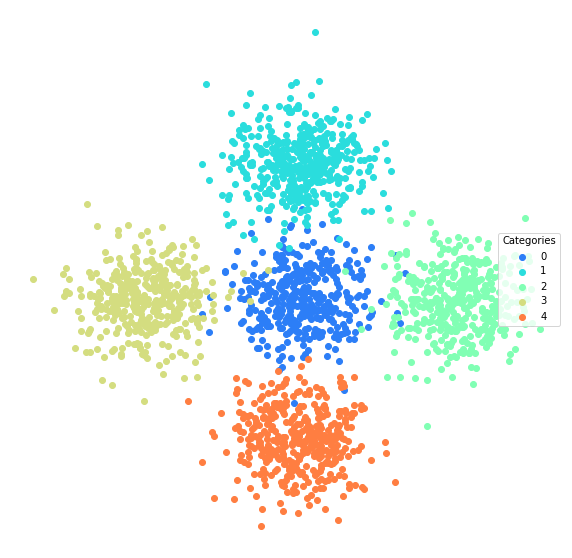

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

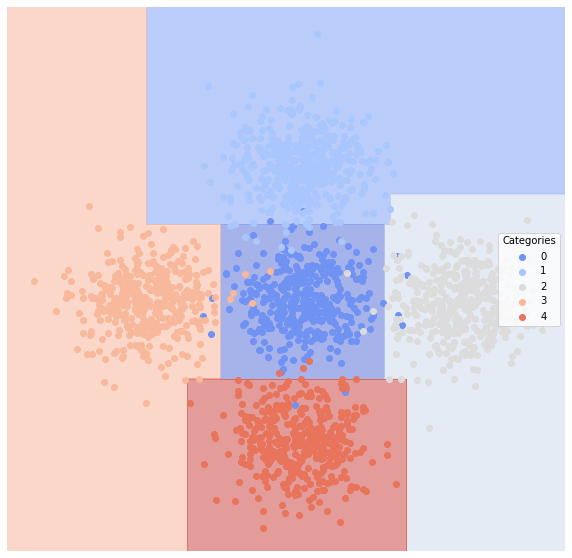

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.008,0.991608,0.973214,0.966367,0.990909
1,0.002,0.998795,0.988372,0.988372,1.000000
2,0.002,0.995238,1.000000,0.992476,0.990476
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.004,0.989691,1.000000,0.983381,0.979381


Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.992

What happens if we trim the tree?

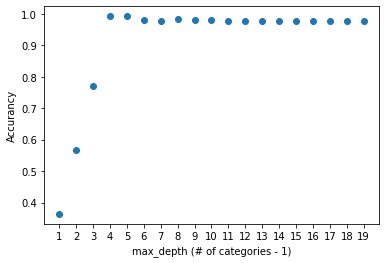

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.xticks(range(1, 20))
plt.ylabel('Accurancy')
plt.xlabel('max_depth (# of categories - 1)')
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

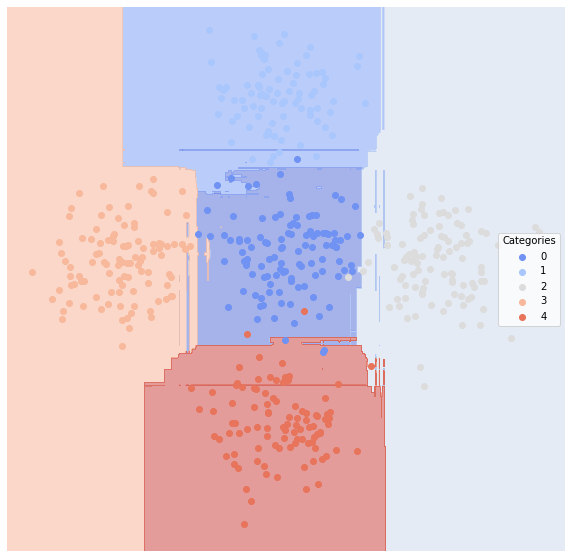

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.016,0.973427,0.972222,0.938030,0.954545
1,0.004,0.997590,0.977011,0.977011,1.000000
2,0.004,0.993972,0.990476,0.983043,0.990476
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.012,0.980814,0.969072,0.945101,0.969072


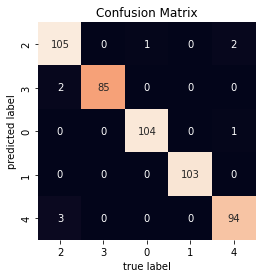

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

Let's first start with a decision tree classifier for our training/test data

In [53]:
#training 

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_Cande.xlsx')
#news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df['text'] = news_df['text'].apply(clean_raw_text)
news_df = news_df.drop(news_df.columns[[0]], axis=1)
news_df['category'] = news_df['category'].apply(int)
news_df = news_df[news_df['category'] != 4]
news_df['category'] = news_df['category'].apply(lambda x: x-1)
news_df

,text,category
0,"Navy pilot Lt. Cmdr. Mike "" MOB "" Tremel , lef...",0
1,"the war on terror began 17 years ago , the lar...",2
2,Ministry Eyes Blockchain to Boost Trust In Cha...,1
3,impact of ' technological change and innovatio...,1
5,"pauses its review of T-Mobile , Sprint merger ...",1
6,launches Ghana 's first satellite internet ser...,2
7,watch the news on television at a train statio...,1
8,'s promising blockchain asset exchange has onc...,2
9,Are 3 Hot Things to Know About Stocks Right No...,1
10,"new Harris Poll has just been released : "" the...",0


In [54]:
news_df_train, news_df_test = sklearn.model_selection.train_test_split(news_df, test_size=.2)

In [55]:
# Fit vectors
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(news_df_train['text'])

# Create vectors
news_df_train['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

# PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(news_df_train['vect'], axis=0))
news_df_train['pca'] = [r for r in reduced_data]
news_df_train['pca_reduced_10'] = news_df_train['pca'].apply(lambda x: x[:10])

# Tree
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=3,random_state=0)
clf_tree.fit(np.stack(news_df_train['pca_reduced_10'], axis=0), news_df_train['category'])

DecisionTreeClassifier(max_depth=3, random_state=0)

In [56]:
# Check decision tree score (training)
clf_tree.score(np.stack(news_df_train['pca_reduced_10'], axis=0), news_df_train['category'])

0.9090909090909091

In [59]:
#testing

#Create vectors
TFVects_test = TFVectorizer.transform(news_df_test['text'])
news_df_test['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(news_df_test['vect'], axis=0))
news_df_test['pca'] = [r for r in reduced_data_test]
news_df_test['pca_reduced_10'] = news_df_test['pca'].apply(lambda x: x[:10])

#Test
clf_tree.score(np.stack(news_df_test['pca_reduced_10'], axis=0), news_df_test['category'])

0.16666666666666666

In [102]:
news_df_train_to_evaluate = pandas.DataFrame()
news_df_train_to_evaluate['vect']= news_df_train['pca_reduced_10']
news_df_train_to_evaluate['category']= news_df_train['category']
lucem_illud.evaluateClassifier(clf_tree, news_df_train_to_evaluate)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.227273,0.500000,0.000,0.227273,0.000000
1,0.409091,0.619658,0.500,0.479798,0.777778
2,0.454545,0.508929,0.375,0.367898,0.375000


In [62]:
sklearn.metrics.accuracy_score(news_df_train_to_evaluate['category'],clf_tree.predict(np.stack(news_df_train_to_evaluate['vect'], axis = 0)))

0.9090909090909091

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


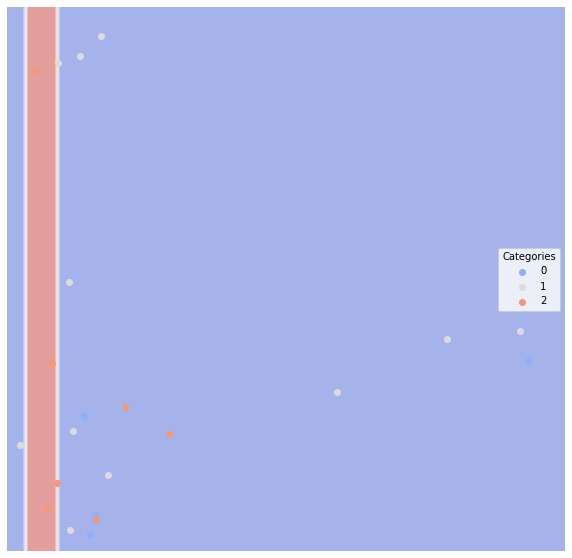

In [63]:
lucem_illud.plotregions(clf_tree, news_df_train_to_evaluate)

Now let's extrapolate our decision tree

In [80]:
# Extrapolation

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_US_Technology_ies.xlsx')
news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df_reduced['body'] = news_df_reduced['body'].apply(clean_raw_text)

In [81]:
news_df_extrapolated = pandas.DataFrame(dtype='object')
news_df_extrapolated ['body'] = news_df_reduced['body']
news_df_extrapolated

,body
0,Thank you for visiting nature.com . You are us...
1,Mayans M.C. does n't shy away from sending a c...
2,Japan Is About to Start Testing The Feasibilit...
3,Krebs on Security In-depth security news and ...
4,Morgan Stanley has valued Tesla 's autonomous ...
...,...
1811,"In the early 1990s , the burgeoning black meta..."
1812,The furor that has flared around virtually eve...
1813,"We saw final moments of MH370 , say fishermen ..."
1814,The Coming of Age of Biotechnology Since its b...


In [82]:
#Create vectors
TFVects_extrapolated = TFVectorizer.transform(news_df_extrapolated['body'])
news_df_extrapolated['vect'] = [np.array(v).flatten() for v in TFVects_extrapolated.todense()]

#PCA
reduced_data_extrapolated = pca.transform(np.stack(news_df_extrapolated['vect'], axis=0))
news_df_extrapolated['pca'] = [r for r in reduced_data_extrapolated]
news_df_extrapolated['pca_reduced_10'] = news_df_extrapolated['pca'].apply(lambda x: x[:10])

news_df_extrapolated

,body,vect,pca,pca_reduced_10
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.09004784132401929, -0.04713941361053435, -...","[-0.09004784132401929, -0.04713941361053435, -..."
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07571322556358062, -0.0721348360205197, 0....","[-0.07571322556358062, -0.0721348360205197, 0...."
2,Japan Is About to Start Testing The Feasibilit...,"[0.29254505296667843, 0.10771919481832518, 0.0...","[-0.08767425008096495, -0.06252105693835766, 0...","[-0.08767425008096495, -0.06252105693835766, 0..."
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.04063252715481799,...","[-0.01067331201004932, -0.05107553643099741, 0...","[-0.01067331201004932, -0.05107553643099741, 0..."
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.08747893764558287, 0.0, 0.0, 0.2624368...","[0.02759174585046211, -0.0356536562723247, -0....","[0.02759174585046211, -0.0356536562723247, -0...."
...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.05546698310962961, 0.0, 0.0, 0.0,...","[0.0303061705760945, -0.06627571798290974, 0.0...","[0.0303061705760945, -0.06627571798290974, 0.0..."
1812,The furor that has flared around virtually eve...,"[0.0, 0.06709390940746991, 0.06073814208771732...","[-0.06284333261310951, -0.08925126134051235, 0...","[-0.06284333261310951, -0.08925126134051235, 0..."
1813,"We saw final moments of MH370 , say fishermen ...","[0.07970080874103323, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.06726468859469573, -0.16587123784605928, 0...","[-0.06726468859469573, -0.16587123784605928, 0..."
1814,The Coming of Age of Biotechnology Since its b...,"[0.041233688045668196, 0.04554846814834322, 0....","[-0.054346989764226875, -0.08066968495225961, ...","[-0.054346989764226875, -0.08066968495225961, ..."


In [83]:
news_df_extrapolated['predicted_category'] = clf_tree.predict(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['labeled_pred_cat'] = news_df_extrapolated['predicted_category'].apply(lambda x: ['negative', 'neutral',  'positive'][x])

predict_proba = clf_tree.predict_proba(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['proba negative'] = predict_proba[:, 0]
news_df_extrapolated['proba neutral'] = predict_proba[:, 1]
news_df_extrapolated['proba positive'] = predict_proba[:, 2]
news_df_extrapolated

,body,vect,pca,pca_reduced_10,predicted_category,labeled_pred_cat,proba negative,proba neutral,proba positive
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.09004784132401929, -0.04713941361053435, -...","[-0.09004784132401929, -0.04713941361053435, -...",1,neutral,0.181818,0.818182,0.0
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07571322556358062, -0.0721348360205197, 0....","[-0.07571322556358062, -0.0721348360205197, 0....",1,neutral,0.181818,0.818182,0.0
2,Japan Is About to Start Testing The Feasibilit...,"[0.29254505296667843, 0.10771919481832518, 0.0...","[-0.08767425008096495, -0.06252105693835766, 0...","[-0.08767425008096495, -0.06252105693835766, 0...",1,neutral,0.181818,0.818182,0.0
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.04063252715481799,...","[-0.01067331201004932, -0.05107553643099741, 0...","[-0.01067331201004932, -0.05107553643099741, 0...",1,neutral,0.181818,0.818182,0.0
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.08747893764558287, 0.0, 0.0, 0.2624368...","[0.02759174585046211, -0.0356536562723247, -0....","[0.02759174585046211, -0.0356536562723247, -0....",1,neutral,0.181818,0.818182,0.0
...,...,...,...,...,...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.05546698310962961, 0.0, 0.0, 0.0,...","[0.0303061705760945, -0.06627571798290974, 0.0...","[0.0303061705760945, -0.06627571798290974, 0.0...",1,neutral,0.181818,0.818182,0.0
1812,The furor that has flared around virtually eve...,"[0.0, 0.06709390940746991, 0.06073814208771732...","[-0.06284333261310951, -0.08925126134051235, 0...","[-0.06284333261310951, -0.08925126134051235, 0...",1,neutral,0.181818,0.818182,0.0
1813,"We saw final moments of MH370 , say fishermen ...","[0.07970080874103323, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.06726468859469573, -0.16587123784605928, 0...","[-0.06726468859469573, -0.16587123784605928, 0...",1,neutral,0.181818,0.818182,0.0
1814,The Coming of Age of Biotechnology Since its b...,"[0.041233688045668196, 0.04554846814834322, 0....","[-0.054346989764226875, -0.08066968495225961, ...","[-0.054346989764226875, -0.08066968495225961, ...",1,neutral,0.181818,0.818182,0.0


In [84]:
news_df_extrapolated.value_counts('labeled_pred_cat')

labeled_pred_cat
neutral     1782
positive      32
negative       2
dtype: int64

In [157]:
sklearn.metrics.accuracy_score(news_df_extrapolated['category'],clf_tree.predict(np.stack(news_df_extrapolated['vect'], axis = 0)))

0.4090909090909091

In [158]:
#calculate accuracy

news_df_extrapolated = pandas.DataFrame()
news_df_extrapolated['vect']= news_df_train['pca_reduced_10']
news_df_extrapolated['category']= news_df_train['category']
lucem_illud.evaluateClassifier(clf_tree, news_df_extrapolated)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.272727,0.470588,0.0,0.227273,0.000000
1,0.590909,0.425000,0.4,0.421818,0.600000
2,0.318182,0.614286,0.5,0.396104,0.428571


In [159]:
sklearn.metrics.accuracy_score(news_df_extrapolated['category'],clf_tree.predict(np.stack(news_df_extrapolated['vect'], axis = 0)))

0.4090909090909091

Now let's create the bag and then the ensemble for the random forest, which seems to perform very well in terms of precision.

In [64]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=5) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [65]:
bag.fit(np.stack(news_df_train_to_evaluate['vect'], axis =0), news_df_train_to_evaluate['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


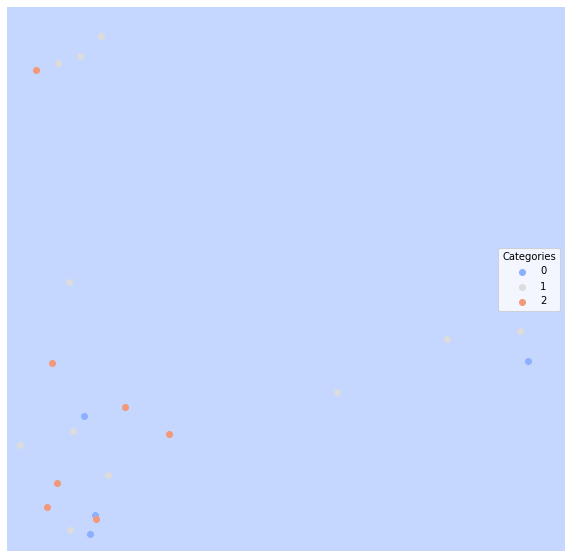

In [66]:
lucem_illud.plotregions(bag, news_df_train_to_evaluate)

In [67]:
lucem_illud.evaluateClassifier(bag, news_df_train_to_evaluate)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0


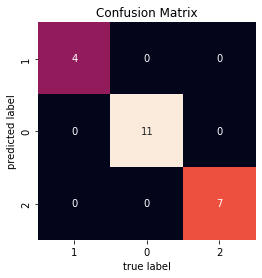

In [68]:
lucem_illud.plotConfusionMatrix(bag, news_df_train_to_evaluate)

In [69]:
sklearn.metrics.accuracy_score(news_df_train_to_evaluate['category'],bag.predict(np.stack(news_df_train_to_evaluate['vect'], axis = 0)))

1.0

Now let's extrapolate the ensemble

In [87]:
# Extrapolation

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_US_Technology_ies.xlsx')
news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df_reduced['body'] = news_df_reduced['body'].apply(clean_raw_text)

In [88]:
news_df_extrapolated = pandas.DataFrame(dtype='object')
news_df_extrapolated ['body'] = news_df_reduced['body']
news_df_extrapolated

,body
0,Thank you for visiting nature.com . You are us...
1,Mayans M.C. does n't shy away from sending a c...
2,Japan Is About to Start Testing The Feasibilit...
3,Krebs on Security In-depth security news and ...
4,Morgan Stanley has valued Tesla 's autonomous ...
...,...
1811,"In the early 1990s , the burgeoning black meta..."
1812,The furor that has flared around virtually eve...
1813,"We saw final moments of MH370 , say fishermen ..."
1814,The Coming of Age of Biotechnology Since its b...


In [90]:
#Create vectors
TFVects_extrapolated = TFVectorizer.transform(news_df_extrapolated['body'])
news_df_extrapolated['vect'] = [np.array(v).flatten() for v in TFVects_extrapolated.todense()]

#PCA
reduced_data_extrapolated = pca.transform(np.stack(news_df_extrapolated['vect'], axis=0))
news_df_extrapolated['pca'] = [r for r in reduced_data_extrapolated]
news_df_extrapolated['pca_reduced_10'] = news_df_extrapolated['pca'].apply(lambda x: x[:10])

news_df_extrapolated

,body,vect,pca,pca_reduced_10
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.09004784132401929, -0.04713941361053435, -...","[-0.09004784132401929, -0.04713941361053435, -..."
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07571322556358062, -0.0721348360205197, 0....","[-0.07571322556358062, -0.0721348360205197, 0...."
2,Japan Is About to Start Testing The Feasibilit...,"[0.29254505296667843, 0.10771919481832518, 0.0...","[-0.08767425008096495, -0.06252105693835766, 0...","[-0.08767425008096495, -0.06252105693835766, 0..."
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.04063252715481799,...","[-0.01067331201004932, -0.05107553643099741, 0...","[-0.01067331201004932, -0.05107553643099741, 0..."
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.08747893764558287, 0.0, 0.0, 0.2624368...","[0.02759174585046211, -0.0356536562723247, -0....","[0.02759174585046211, -0.0356536562723247, -0...."
...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.05546698310962961, 0.0, 0.0, 0.0,...","[0.0303061705760945, -0.06627571798290974, 0.0...","[0.0303061705760945, -0.06627571798290974, 0.0..."
1812,The furor that has flared around virtually eve...,"[0.0, 0.06709390940746991, 0.06073814208771732...","[-0.06284333261310951, -0.08925126134051235, 0...","[-0.06284333261310951, -0.08925126134051235, 0..."
1813,"We saw final moments of MH370 , say fishermen ...","[0.07970080874103323, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.06726468859469573, -0.16587123784605928, 0...","[-0.06726468859469573, -0.16587123784605928, 0..."
1814,The Coming of Age of Biotechnology Since its b...,"[0.041233688045668196, 0.04554846814834322, 0....","[-0.054346989764226875, -0.08066968495225961, ...","[-0.054346989764226875, -0.08066968495225961, ..."


In [91]:
news_df_extrapolated['predicted_category'] = bag.predict(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['labeled_pred_cat'] = news_df_extrapolated['predicted_category'].apply(lambda x: ['negative', 'neutral',  'positive'][x])

predict_proba = bag.predict_proba(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['proba negative'] = predict_proba[:, 0]
news_df_extrapolated['proba neutral'] = predict_proba[:, 1]
news_df_extrapolated['proba positive'] = predict_proba[:, 2]
news_df_extrapolated

,body,vect,pca,pca_reduced_10,predicted_category,labeled_pred_cat,proba negative,proba neutral,proba positive
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.09004784132401929, -0.04713941361053435, -...","[-0.09004784132401929, -0.04713941361053435, -...",1,neutral,0.17,0.70,0.13
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07571322556358062, -0.0721348360205197, 0....","[-0.07571322556358062, -0.0721348360205197, 0....",1,neutral,0.17,0.74,0.09
2,Japan Is About to Start Testing The Feasibilit...,"[0.29254505296667843, 0.10771919481832518, 0.0...","[-0.08767425008096495, -0.06252105693835766, 0...","[-0.08767425008096495, -0.06252105693835766, 0...",1,neutral,0.17,0.60,0.23
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.04063252715481799,...","[-0.01067331201004932, -0.05107553643099741, 0...","[-0.01067331201004932, -0.05107553643099741, 0...",1,neutral,0.24,0.60,0.16
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.08747893764558287, 0.0, 0.0, 0.2624368...","[0.02759174585046211, -0.0356536562723247, -0....","[0.02759174585046211, -0.0356536562723247, -0....",1,neutral,0.18,0.70,0.12
...,...,...,...,...,...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.05546698310962961, 0.0, 0.0, 0.0,...","[0.0303061705760945, -0.06627571798290974, 0.0...","[0.0303061705760945, -0.06627571798290974, 0.0...",1,neutral,0.18,0.68,0.14
1812,The furor that has flared around virtually eve...,"[0.0, 0.06709390940746991, 0.06073814208771732...","[-0.06284333261310951, -0.08925126134051235, 0...","[-0.06284333261310951, -0.08925126134051235, 0...",1,neutral,0.18,0.60,0.22
1813,"We saw final moments of MH370 , say fishermen ...","[0.07970080874103323, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.06726468859469573, -0.16587123784605928, 0...","[-0.06726468859469573, -0.16587123784605928, 0...",1,neutral,0.22,0.53,0.25
1814,The Coming of Age of Biotechnology Since its b...,"[0.041233688045668196, 0.04554846814834322, 0....","[-0.054346989764226875, -0.08066968495225961, ...","[-0.054346989764226875, -0.08066968495225961, ...",1,neutral,0.10,0.59,0.31


In [92]:
news_df_extrapolated.value_counts('labeled_pred_cat')

labeled_pred_cat
neutral     1725
positive      87
negative       4
dtype: int64

In [93]:
sklearn.metrics.accuracy_score(news_df_train_to_evaluate['category'],bag.predict(np.stack(news_df_train_to_evaluate['vect'], axis = 0)))

1.0

The bag ensemble method seems to perform better than the decision tree, but both are very good (they also provide more variability in the predicted categories)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [70]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = data_path) #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)



Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


In [ ]:
#newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
#newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [71]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [72]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [73]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [74]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [75]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.graphics,0.416957,0.628308,0.367631,0.342055,0.728238
sci.space,0.273519,0.605916,0.498442,0.349706,0.340426
talk.religion.misc,0.274681,0.620493,0.310268,0.237572,0.458746
soc.religion.christian,0.274100,0.510785,0.650000,0.287713,0.027197


And lets look at the testing data

In [76]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.23897911832946636


Let's produce another confusion matrix:

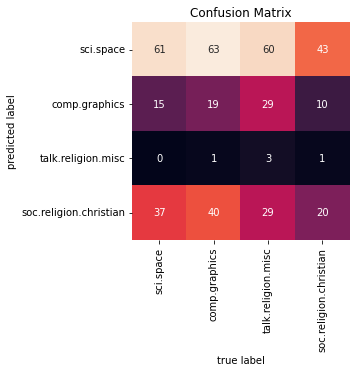

In [77]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

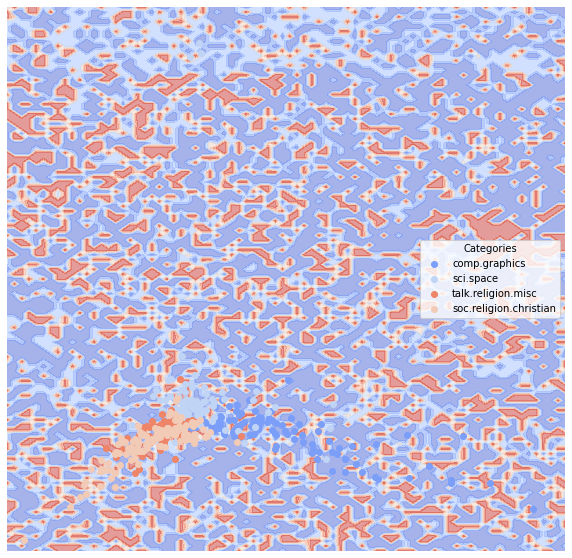

In [78]:
lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

Let's first start with a K-nearest Neighbors classifier for our training/test data

In [160]:
#training 

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_Cande.xlsx')
#news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df['text'] = news_df['text'].apply(clean_raw_text)
news_df = news_df.drop(news_df.columns[[0]], axis=1)
news_df['category'] = news_df['category'].apply(int)
news_df = news_df[news_df['category'] != 4]
news_df['category'] = news_df['category'].apply(lambda x: x-1)
news_df

,text,category
0,"Navy pilot Lt. Cmdr. Mike "" MOB "" Tremel , lef...",0
1,"the war on terror began 17 years ago , the lar...",2
2,Ministry Eyes Blockchain to Boost Trust In Cha...,1
3,impact of ' technological change and innovatio...,1
5,"pauses its review of T-Mobile , Sprint merger ...",1
6,launches Ghana 's first satellite internet ser...,2
7,watch the news on television at a train statio...,1
8,'s promising blockchain asset exchange has onc...,2
9,Are 3 Hot Things to Know About Stocks Right No...,1
10,"new Harris Poll has just been released : "" the...",0


In [161]:
news_df_train, news_df_test = sklearn.model_selection.train_test_split(news_df, test_size=.2)

In [96]:
#n_neighbors = 15
#weights="uniform"
#clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [162]:
# Fit vectors
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(news_df_train['text'])

# Create vectors
news_df_train['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

# PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(news_df_train['vect'], axis=0))
news_df_train['pca'] = [r for r in reduced_data]
news_df_train['pca_reduced_10'] = news_df_train['pca'].apply(lambda x: x[:10])

# K-Nearest Neighbors
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf_knearest.fit(np.stack(news_df_train['pca_reduced_10'], axis=0), news_df_train['category'])

KNeighborsClassifier(n_neighbors=15)

In [163]:
# Check knearest score (training)
clf_knearest.score(np.stack(news_df_train['pca_reduced_10'], axis=0), news_df_train['category'])

0.2727272727272727

In [164]:
#testing

#Create vectors
TFVects_test = TFVectorizer.transform(news_df_test['text'])
news_df_test['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(news_df_test['vect'], axis=0))
news_df_test['pca'] = [r for r in reduced_data_test]
news_df_test['pca_reduced_10'] = news_df_test['pca'].apply(lambda x: x[:10])

#Test
clf_knearest.score(np.stack(news_df_test['pca_reduced_10'], axis=0), news_df_test['category'])

0.6666666666666666

In [165]:
news_df_train_to_evaluate = pandas.DataFrame()
news_df_train_to_evaluate['vect']= news_df_train['pca_reduced_10']
news_df_train_to_evaluate['category']= news_df_train['category']
lucem_illud.evaluateClassifier(clf_knearest, news_df_train_to_evaluate)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.318182,0.468750,0.0,0.272727,0.00
1,0.727273,0.375000,0.3,0.315909,0.75
2,0.409091,0.464286,0.0,0.363636,0.00


In [166]:
sklearn.metrics.accuracy_score(news_df_train_to_evaluate['category'],clf_knearest.predict(np.stack(news_df_train_to_evaluate['vect'], axis = 0)))

0.2727272727272727

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


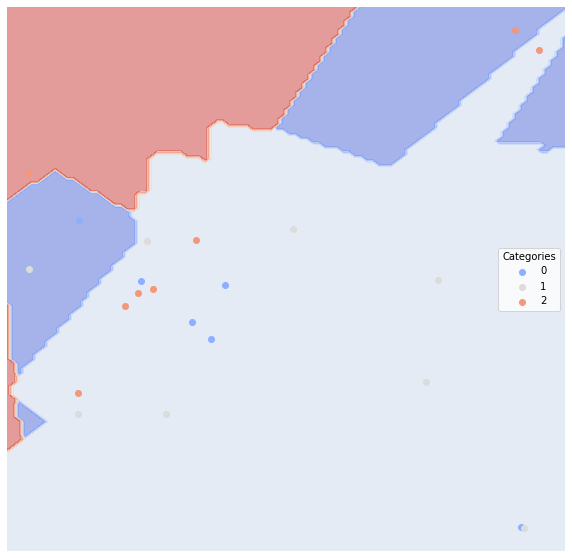

In [167]:
lucem_illud.plotregions(clf_knearest, news_df_train_to_evaluate)

Compared with the decision trees, K-Nearest Neighbors perform poorer. Now let's extrapolate our classifier to uncoded dataset.

In [168]:
# Extrapolation

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_US_Technology_ies.xlsx')
news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df_reduced['body'] = news_df_reduced['body'].apply(clean_raw_text)

In [169]:
news_df_extrapolated = pandas.DataFrame(dtype='object')
news_df_extrapolated ['body'] = news_df_reduced['body']
news_df_extrapolated

,body
0,Thank you for visiting nature.com . You are us...
1,Mayans M.C. does n't shy away from sending a c...
2,Japan Is About to Start Testing The Feasibilit...
3,Krebs on Security In-depth security news and ...
4,Morgan Stanley has valued Tesla 's autonomous ...
...,...
1811,"In the early 1990s , the burgeoning black meta..."
1812,The furor that has flared around virtually eve...
1813,"We saw final moments of MH370 , say fishermen ..."
1814,The Coming of Age of Biotechnology Since its b...


In [170]:
#Create vectors
TFVects_extrapolated = TFVectorizer.transform(news_df_extrapolated['body'])
news_df_extrapolated['vect'] = [np.array(v).flatten() for v in TFVects_extrapolated.todense()]

#PCA
reduced_data_extrapolated = pca.transform(np.stack(news_df_extrapolated['vect'], axis=0))
news_df_extrapolated['pca'] = [r for r in reduced_data_extrapolated]
news_df_extrapolated['pca_reduced_10'] = news_df_extrapolated['pca'].apply(lambda x: x[:10])

news_df_extrapolated

,body,vect,pca,pca_reduced_10
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.162...","[-0.06312934516905133, -0.022618579033727586, ...","[-0.06312934516905133, -0.022618579033727586, ..."
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.008512499264203947, 0.04530403151468848, 0...","[-0.008512499264203947, 0.04530403151468848, 0..."
2,Japan Is About to Start Testing The Feasibilit...,"[0.48384166899397524, 0.17815729397933827, 0.0...","[-0.08115130427485318, 0.02912966109942488, -0...","[-0.08115130427485318, 0.02912966109942488, -0..."
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.039361384920234076, 0.0...","[-0.08960846521062225, -0.02744278982594986, -...","[-0.08960846521062225, -0.02744278982594986, -..."
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.08947617894857073, 0.0, 0.0, 0.0, 0.0,...","[0.018670008115961693, -0.02582989232323822, -...","[0.018670008115961693, -0.02582989232323822, -..."
...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.08733612637773948, 0.0, 0.0, 0.0,...","[0.03957386901270517, -0.11435971218009293, -0...","[0.03957386901270517, -0.11435971218009293, -0..."
1812,The furor that has flared around virtually eve...,"[0.0, 0.07364677969391349, 0.06667026275344318...","[-0.09355426842234556, 0.0172185861770257, -0....","[-0.09355426842234556, 0.0172185861770257, -0...."
1813,"We saw final moments of MH370 , say fishermen ...","[0.07442760727884118, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.08328208975994897, -0.048955426576738556, ...","[-0.08328208975994897, -0.048955426576738556, ..."
1814,The Coming of Age of Biotechnology Since its b...,"[0.04332977164435906, 0.04786389035664762, 0.0...","[0.12228635430105735, 0.21145912402498437, 0.0...","[0.12228635430105735, 0.21145912402498437, 0.0..."


In [171]:
news_df_extrapolated['predicted_category'] = clf_knearest.predict(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['labeled_pred_cat'] = news_df_extrapolated['predicted_category'].apply(lambda x: ['negative', 'neutral',  'positive'][x])

predict_proba = clf_knearest.predict_proba(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['proba negative'] = predict_proba[:, 0]
news_df_extrapolated['proba neutral'] = predict_proba[:, 1]
news_df_extrapolated['proba positive'] = predict_proba[:, 2]
news_df_extrapolated

,body,vect,pca,pca_reduced_10,predicted_category,labeled_pred_cat,proba negative,proba neutral,proba positive
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.162...","[-0.06312934516905133, -0.022618579033727586, ...","[-0.06312934516905133, -0.022618579033727586, ...",1,neutral,0.266667,0.466667,0.266667
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.008512499264203947, 0.04530403151468848, 0...","[-0.008512499264203947, 0.04530403151468848, 0...",1,neutral,0.200000,0.400000,0.400000
2,Japan Is About to Start Testing The Feasibilit...,"[0.48384166899397524, 0.17815729397933827, 0.0...","[-0.08115130427485318, 0.02912966109942488, -0...","[-0.08115130427485318, 0.02912966109942488, -0...",1,neutral,0.266667,0.400000,0.333333
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.039361384920234076, 0.0...","[-0.08960846521062225, -0.02744278982594986, -...","[-0.08960846521062225, -0.02744278982594986, -...",1,neutral,0.266667,0.400000,0.333333
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.08947617894857073, 0.0, 0.0, 0.0, 0.0,...","[0.018670008115961693, -0.02582989232323822, -...","[0.018670008115961693, -0.02582989232323822, -...",1,neutral,0.200000,0.533333,0.266667
...,...,...,...,...,...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.08733612637773948, 0.0, 0.0, 0.0,...","[0.03957386901270517, -0.11435971218009293, -0...","[0.03957386901270517, -0.11435971218009293, -0...",1,neutral,0.266667,0.533333,0.200000
1812,The furor that has flared around virtually eve...,"[0.0, 0.07364677969391349, 0.06667026275344318...","[-0.09355426842234556, 0.0172185861770257, -0....","[-0.09355426842234556, 0.0172185861770257, -0....",1,neutral,0.266667,0.466667,0.266667
1813,"We saw final moments of MH370 , say fishermen ...","[0.07442760727884118, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.08328208975994897, -0.048955426576738556, ...","[-0.08328208975994897, -0.048955426576738556, ...",1,neutral,0.133333,0.466667,0.400000
1814,The Coming of Age of Biotechnology Since its b...,"[0.04332977164435906, 0.04786389035664762, 0.0...","[0.12228635430105735, 0.21145912402498437, 0.0...","[0.12228635430105735, 0.21145912402498437, 0.0...",1,neutral,0.133333,0.466667,0.400000


In [172]:
news_df_extrapolated.value_counts('labeled_pred_cat')

labeled_pred_cat
neutral     1782
negative      17
positive      17
dtype: int64

In [178]:
#calculate accuracy

news_df_extrapolated = pandas.DataFrame()
news_df_extrapolated['vect']= news_df_train['pca_reduced_10']
news_df_extrapolated['category']= news_df_train['category']
lucem_illud.evaluateClassifier(clf_knearest, news_df_extrapolated)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.227273,0.641176,0.500000,0.336364,0.400000
1,0.590909,0.416667,0.384615,0.419580,0.500000
2,0.363636,0.542857,0.400000,0.341558,0.285714


In [179]:
sklearn.metrics.accuracy_score(news_df_extrapolated['category'],clf_knearest.predict(np.stack(news_df_extrapolated['vect'], axis = 0)))

0.4090909090909091

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [114]:
redditDf = pandas.read_csv(f'{data_path}/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [115]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [116]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [117]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [118]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.018750,0.968461,0.987654,0.945182,0.941176
Tales From Tech Support,0.003125,0.994048,1.000000,0.991220,0.988095
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006250,0.995763,0.976744,0.976744,1.000000
Relationships,0.015625,0.984632,0.942857,0.931910,0.985075


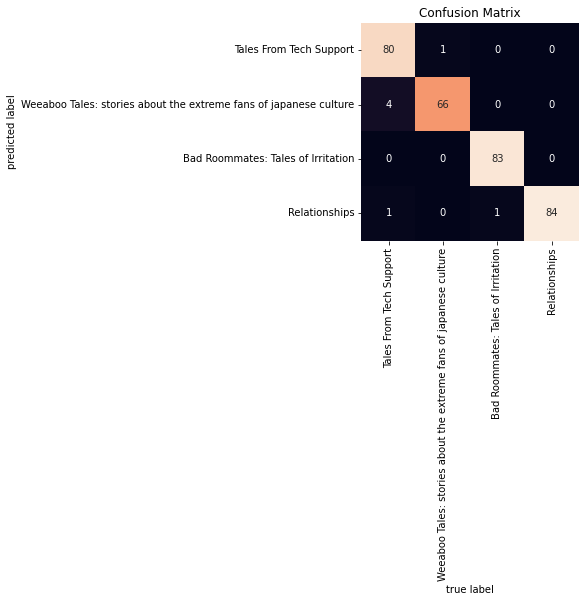

In [119]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

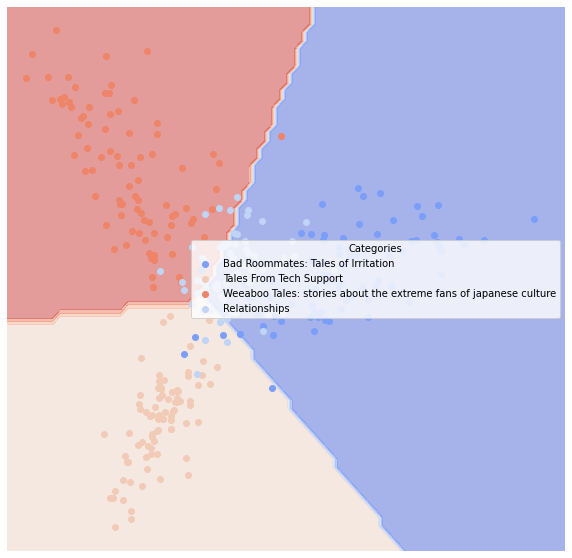

In [120]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/multilayerperceptron_network.png?raw=1) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales: stories about the extreme fans of japanese culture,0.012500,0.975309,1.000000,0.963117,0.950617
Tales From Tech Support,0.009375,0.993724,0.964286,0.964286,1.000000
Relationships,0.021875,0.971837,0.947368,0.918849,0.960000
Bad Roommates: Tales of Irritation,0.018750,0.975599,0.963855,0.938392,0.963855


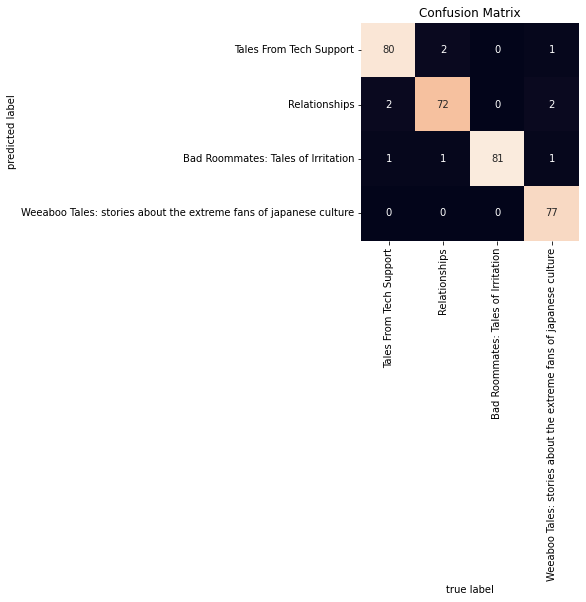

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

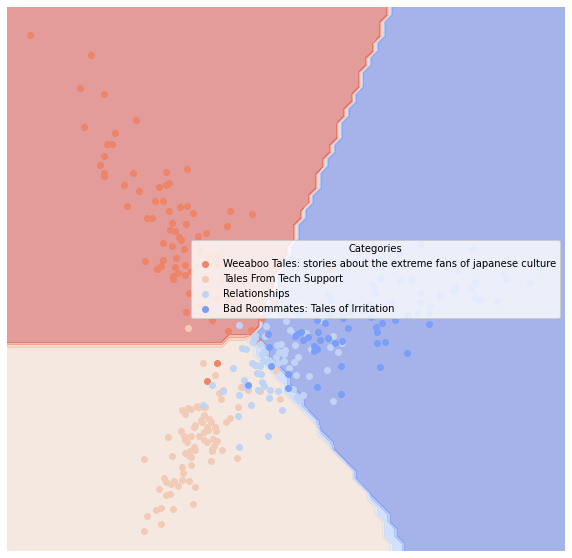

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [175]:
#training 

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_Cande.xlsx')
#news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df['text'] = news_df['text'].apply(clean_raw_text)
news_df = news_df.drop(news_df.columns[[0]], axis=1)
news_df['category'] = news_df['category'].apply(int)
news_df = news_df[news_df['category'] != 4]
news_df['category'] = news_df['category'].apply(lambda x: x-1)
news_df

,text,category
0,"Navy pilot Lt. Cmdr. Mike "" MOB "" Tremel , lef...",0
1,"the war on terror began 17 years ago , the lar...",2
2,Ministry Eyes Blockchain to Boost Trust In Cha...,1
3,impact of ' technological change and innovatio...,1
5,"pauses its review of T-Mobile , Sprint merger ...",1
6,launches Ghana 's first satellite internet ser...,2
7,watch the news on television at a train statio...,1
8,'s promising blockchain asset exchange has onc...,2
9,Are 3 Hot Things to Know About Stocks Right No...,1
10,"new Harris Poll has just been released : "" the...",0


In [176]:
#dividing the dataset 

news_df_train, news_df_test = sklearn.model_selection.train_test_split(news_df, test_size=.2)

In [180]:
# Fit vectors
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(news_df_train['text'])

# Create vectors
news_df_train['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

# PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(news_df_train['vect'], axis=0))
news_df_train['pca'] = [r for r in reduced_data]
news_df_train['pca_reduced_10'] = news_df_train['pca'].apply(lambda x: x[:10])

# Neural Nets
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(news_df_train['pca_reduced_10'], axis=0), news_df_train['category'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier()

In [181]:
# Check neural nets score (training)
clf_nn.score(np.stack(news_df_train['pca_reduced_10'], axis=0), news_df_train['category'])

1.0

In [182]:
# check with testing

#Create vectors
TFVects_test = TFVectorizer.transform(news_df_test['text'])
news_df_test['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(news_df_test['vect'], axis=0))
news_df_test['pca'] = [r for r in reduced_data_test]
news_df_test['pca_reduced_10'] = news_df_test['pca'].apply(lambda x: x[:10])

#Test
clf_nn.score(np.stack(news_df_test['pca_reduced_10'], axis=0), news_df_test['category'])

0.6666666666666666

In [183]:
news_df_train_to_evaluate = pandas.DataFrame()
news_df_train_to_evaluate['vect']= news_df_train['pca_reduced_10']
news_df_train_to_evaluate['category']= news_df_train['category']
lucem_illud.evaluateClassifier(clf_nn, news_df_train_to_evaluate)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0


In [184]:
sklearn.metrics.accuracy_score(news_df_train_to_evaluate['category'],clf_nn.predict(np.stack(news_df_train_to_evaluate['vect'], axis = 0)))

1.0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


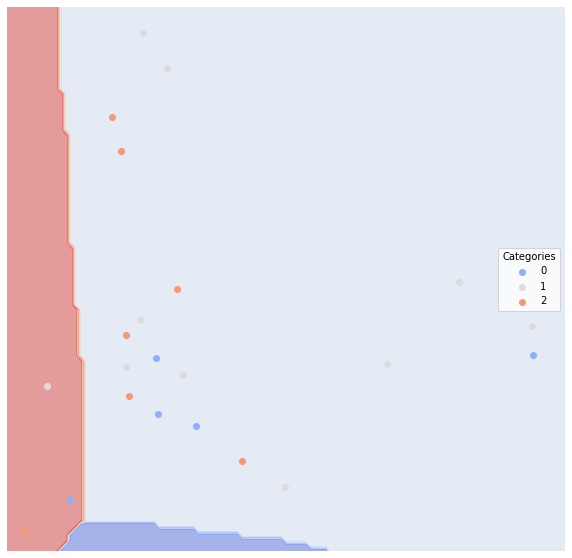

In [186]:
lucem_illud.plotregions(clf_nn, news_df_train_to_evaluate)

New let's extrapolate our Neural Nets classifier

In [187]:
# Extrapolation

import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW_US_Technology_ies.xlsx')
news_df_reduced = news_df.drop(news_df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)

def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text

news_df_reduced['body'] = news_df_reduced['body'].apply(clean_raw_text)

In [188]:
news_df_extrapolated = pandas.DataFrame(dtype='object')
news_df_extrapolated ['body'] = news_df_reduced['body']
news_df_extrapolated

,body
0,Thank you for visiting nature.com . You are us...
1,Mayans M.C. does n't shy away from sending a c...
2,Japan Is About to Start Testing The Feasibilit...
3,Krebs on Security In-depth security news and ...
4,Morgan Stanley has valued Tesla 's autonomous ...
...,...
1811,"In the early 1990s , the burgeoning black meta..."
1812,The furor that has flared around virtually eve...
1813,"We saw final moments of MH370 , say fishermen ..."
1814,The Coming of Age of Biotechnology Since its b...


In [189]:
#Create vectors
TFVects_extrapolated = TFVectorizer.transform(news_df_extrapolated['body'])
news_df_extrapolated['vect'] = [np.array(v).flatten() for v in TFVects_extrapolated.todense()]

#PCA
reduced_data_extrapolated = pca.transform(np.stack(news_df_extrapolated['vect'], axis=0))
news_df_extrapolated['pca'] = [r for r in reduced_data_extrapolated]
news_df_extrapolated['pca_reduced_10'] = news_df_extrapolated['pca'].apply(lambda x: x[:10])

news_df_extrapolated

,body,vect,pca,pca_reduced_10
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08281450792147388, -0.004386847021490947, ...","[-0.08281450792147388, -0.004386847021490947, ..."
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05882777875836452, 0.027379943485114196, 0...","[-0.05882777875836452, 0.027379943485114196, 0..."
2,Japan Is About to Start Testing The Feasibilit...,"[0.2960531941191648, 0.10901094163278219, 0.0,...","[-0.0978330973281053, -0.003987290185988875, 0...","[-0.0978330973281053, -0.003987290185988875, 0..."
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.039329677035153505...","[-0.038763152724148764, -0.010049001930172514,...","[-0.038763152724148764, -0.010049001930172514,..."
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.09382718821656787, 0.0, 0.0, 0.2814815...","[0.04697220946326668, -0.008593523738435027, -...","[0.04697220946326668, -0.008593523738435027, -..."
...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.05591107417398486, 0.0, 0.0, 0.0,...","[0.020736076052438424, -0.0010152055146069872,...","[0.020736076052438424, -0.0010152055146069872,..."
1812,The furor that has flared around virtually eve...,"[0.0, 0.06916680981661298, 0.06261467783732742...","[-0.07976534343324762, -0.06840986742317683, -...","[-0.07976534343324762, -0.06840986742317683, -..."
1813,"We saw final moments of MH370 , say fishermen ...","[0.07379454883614957, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.052727581776046965, -0.024370408337119443,...","[-0.052727581776046965, -0.024370408337119443,..."
1814,The Coming of Age of Biotechnology Since its b...,"[0.04116946461478164, 0.04547752424216452, 0.0...","[-0.01714448622087524, -0.07310252942716913, 0...","[-0.01714448622087524, -0.07310252942716913, 0..."


In [190]:
news_df_extrapolated['predicted_category'] = clf_nn.predict(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['labeled_pred_cat'] = news_df_extrapolated['predicted_category'].apply(lambda x: ['negative', 'neutral',  'positive'][x])

predict_proba = clf_nn.predict_proba(np.stack(news_df_extrapolated['pca_reduced_10'], axis=0))
news_df_extrapolated['proba negative'] = predict_proba[:, 0]
news_df_extrapolated['proba neutral'] = predict_proba[:, 1]
news_df_extrapolated['proba positive'] = predict_proba[:, 2]
news_df_extrapolated

,body,vect,pca,pca_reduced_10,predicted_category,labeled_pred_cat,proba negative,proba neutral,proba positive
0,Thank you for visiting nature.com . You are us...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08281450792147388, -0.004386847021490947, ...","[-0.08281450792147388, -0.004386847021490947, ...",1,neutral,0.138338,0.710998,0.150664
1,Mayans M.C. does n't shy away from sending a c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05882777875836452, 0.027379943485114196, 0...","[-0.05882777875836452, 0.027379943485114196, 0...",1,neutral,0.218232,0.667092,0.114676
2,Japan Is About to Start Testing The Feasibilit...,"[0.2960531941191648, 0.10901094163278219, 0.0,...","[-0.0978330973281053, -0.003987290185988875, 0...","[-0.0978330973281053, -0.003987290185988875, 0...",1,neutral,0.097755,0.575508,0.326737
3,Krebs on Security In-depth security news and ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.039329677035153505...","[-0.038763152724148764, -0.010049001930172514,...","[-0.038763152724148764, -0.010049001930172514,...",1,neutral,0.275500,0.594109,0.130391
4,Morgan Stanley has valued Tesla 's autonomous ...,"[0.0, 0.09382718821656787, 0.0, 0.0, 0.2814815...","[0.04697220946326668, -0.008593523738435027, -...","[0.04697220946326668, -0.008593523738435027, -...",1,neutral,0.181496,0.702331,0.116173
...,...,...,...,...,...,...,...,...,...
1811,"In the early 1990s , the burgeoning black meta...","[0.0, 0.0, 0.05591107417398486, 0.0, 0.0, 0.0,...","[0.020736076052438424, -0.0010152055146069872,...","[0.020736076052438424, -0.0010152055146069872,...",1,neutral,0.177404,0.704369,0.118227
1812,The furor that has flared around virtually eve...,"[0.0, 0.06916680981661298, 0.06261467783732742...","[-0.07976534343324762, -0.06840986742317683, -...","[-0.07976534343324762, -0.06840986742317683, -...",1,neutral,0.163448,0.546993,0.289559
1813,"We saw final moments of MH370 , say fishermen ...","[0.07379454883614957, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.052727581776046965, -0.024370408337119443,...","[-0.052727581776046965, -0.024370408337119443,...",1,neutral,0.207147,0.627662,0.165191
1814,The Coming of Age of Biotechnology Since its b...,"[0.04116946461478164, 0.04547752424216452, 0.0...","[-0.01714448622087524, -0.07310252942716913, 0...","[-0.01714448622087524, -0.07310252942716913, 0...",1,neutral,0.032032,0.541942,0.426026


In [191]:
news_df_extrapolated.value_counts('labeled_pred_cat')

labeled_pred_cat
neutral     1682
positive     125
negative       9
dtype: int64

In [192]:
#calculate accuracy

news_df_extrapolated = pandas.DataFrame()
news_df_extrapolated['vect']= news_df_train['pca_reduced_10']
news_df_extrapolated['category']= news_df_train['category']
lucem_illud.evaluateClassifier(clf_nn, news_df_extrapolated)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0


In [193]:
sklearn.metrics.accuracy_score(news_df_extrapolated['category'],clf_nn.predict(np.stack(news_df_extrapolated['vect'], axis = 0)))

1.0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


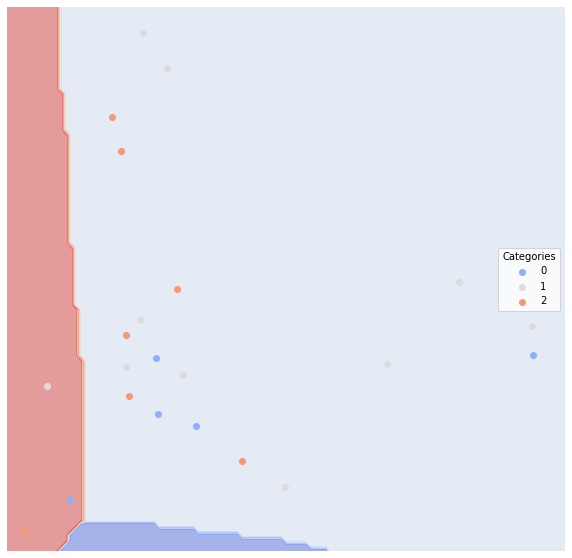

In [194]:
lucem_illud.plotregions(clf_nn, news_df_extrapolated)

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [197]:
pip install transformers

     |████████████████████████████████| 3.5 MB 20.2 MB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 
     |████████████████████████████████| 895 kB 66.0 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 36.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [198]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [222]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question', score: 0.6226, start: 34, end: 95
Answer: 'SQuAD dataset', score: 0.5053, start: 147, end: 160


Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2. 0 and pytorch


## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [223]:
nlp = pipeline("sentiment-analysis")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


label: POSITIVE, with score: 0.9999


In [232]:
import pandas as pd
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW body for coders.xlsx')

In [234]:
news_df

,Unnamed: 0,index,body
0,0,11,Executives from Facebook and Twitter will appe...
1,1,16,"Nasdaq tumbles below 8,000 , on the verge of w..."
2,2,25,Facebook has accused BlackBerry of stealing it...
3,3,38,Dr. John Halamka : Test IT in places ' toleran...
4,4,39,Facebook and Twitter executives assured Congre...
...,...,...,...
149,149,1797,"FRANKSVILLE -- For the third year , the Third ..."
150,150,1801,China Is Growing Cotton and Potatoes on the Fa...
151,151,1807,We noticed that your browser is blocking ads -...
152,152,1808,""" We expect excellence every single day in Jef..."


In [235]:
news_df_reduced = news_df.drop(news_df.columns[[0, 1]], axis=1)
news_df_reduced

,body
0,Executives from Facebook and Twitter will appe...
1,"Nasdaq tumbles below 8,000 , on the verge of w..."
2,Facebook has accused BlackBerry of stealing it...
3,Dr. John Halamka : Test IT in places ' toleran...
4,Facebook and Twitter executives assured Congre...
...,...
149,"FRANKSVILLE -- For the third year , the Third ..."
150,China Is Growing Cotton and Potatoes on the Fa...
151,We noticed that your browser is blocking ads -...
152,""" We expect excellence every single day in Jef..."


In [236]:
def clean_raw_text(text):
    # clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
    clean_text = text.split(' ', 1)[1].replace(r'<p> ', '').replace(r'<h>', '')
    return clean_text
news_df_reduced['body'] = news_df_reduced['body'].apply(clean_raw_text)
news_df_reduced

,body
0,from Facebook and Twitter will appear on Capit...
1,"tumbles below 8,000 , on the verge of worst da..."
2,has accused BlackBerry of stealing its voice-m...
3,John Halamka : Test IT in places ' tolerant of...
4,and Twitter executives assured Congress they a...
...,...
149,"-- For the third year , the Third Ward is pair..."
150,Is Growing Cotton and Potatoes on the Far Side...
151,noticed that your browser is blocking ads - pl...
152,We expect excellence every single day in Jeffe...


In [237]:
news_df_reduced = (
    news_df_reduced
    .assign(sentiment = lambda x: x['body'].apply(lambda s: nlp(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

In [ ]:
news_df_reduced

,index,body,category,sentiment,label,score
0,11,Executives from Facebook and Twitter will appe...,1,"[{'label': 'NEGATIVE', 'score': 0.997824907302...",NEGATIVE,0.997825
1,16,"Nasdaq tumbles below 8,000 , on the verge of w...",0,"[{'label': 'NEGATIVE', 'score': 0.999683260917...",NEGATIVE,0.999683
2,25,Facebook has accused BlackBerry of stealing it...,2,"[{'label': 'NEGATIVE', 'score': 0.999694585800...",NEGATIVE,0.999695
3,38,Dr. John Halamka : Test IT in places ' toleran...,1,"[{'label': 'POSITIVE', 'score': 0.994287073612...",POSITIVE,0.994287
4,39,Facebook and Twitter executives assured Congre...,0,"[{'label': 'NEGATIVE', 'score': 0.998689472675...",NEGATIVE,0.998689
...,...,...,...,...,...,...
149,1797,"FRANKSVILLE -- For the third year , the Third ...",2,"[{'label': 'POSITIVE', 'score': 0.996806859970...",POSITIVE,0.996807
150,1801,China Is Growing Cotton and Potatoes on the Fa...,1,"[{'label': 'NEGATIVE', 'score': 0.838422894477...",NEGATIVE,0.838423
151,1807,We noticed that your browser is blocking ads -...,0,"[{'label': 'POSITIVE', 'score': 0.611728370189...",POSITIVE,0.611728
152,1808,""" We expect excellence every single day in Jef...",0,"[{'label': 'POSITIVE', 'score': 0.995840489864...",POSITIVE,0.995840


In [239]:
news_df_reduced.value_counts('label')

label
NEGATIVE    97
POSITIVE    57
dtype: int64

In [206]:

nlp_q = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


In [ ]:
context = r"""
The electric carmaker said in a statement Friday that in March it will begin delivering its Model 3 
sedans to buyers in China as part of its efforts to expand sales in the country . 
Tesla 's sales in China reportedly have seen some negative effect of the trade issues 
going on between Beijing and Washington . Tesla has two versions of the Model 3 lined up to deliver to 
Chinese buyers . The Model 3 Performance car has a range of almost 370 miles and will start at about the 
equivalent of $81,500 . The Model 3 Dual Motor all-wheel drive vehicle will come with an initial price tag 
of about $72,600 and have a battery range of about 366 miles . By contrast , a Model 3 in the U.S. usually
costs upwards of $55,000 with certain amenities and extras included . 
Tesla is aiming to have a Model 3 on the market in the U.S. for $35,000 at some point this year . 
Rex Crum is the senior web editor for the business section for The Mercury News and Bay Area News Group . 
He also writes about business and technology for @ @ @ @ @ @ @ @ @ @ covered business and technology 
for nearly two decades . A native of Seattle , he remains a diehard Seahawks and Mariners fan and is 
imparting his fandom to his Oakland-native wife and two young daughters . I 've tried a mattress with 
water cooling and another that sways like a boat . I 've worn brainwave-measuring helmets and rested on 
pillows that nudge you when you snore . In the hunt for better sleep , I 've even snuggled up with a robot . 
Ousted Nissan Motor Co Chairman Carlos Ghosn said on Sunday he will remain in Japan and follow restrictions 
by local authorities in exchange for his release from jail in the latest effort to persuade a court to 
grant him bail while he awaits trial on charges of financial misconduct .
"""

In [ ]:
result = nlp(question="How many versions of the model 3 Tesla has for Chinese buyers?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:707: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/question_answering.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for span_id in range(num_spans)


Answer: 'two', score: 0.7166, start: 324, end: 327
Answer: 'better sleep', score: 0.2505, start: 1442, end: 1454
